In [1]:
# Jupyter Notebook Setup for Kalshi Weather Backtest
# Cell 1: Install required packages
"""
Run this first in a new environment:

pip install pandas numpy matplotlib seaborn
pip install requests beautifulsoup4
pip install xarray netcdf4 cfgrib  # For reading GRIB files
pip install cartopy  # For mapping if needed
pip install jupyter ipywidgets  # For interactive widgets
"""

# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xarray as xr
import warnings
from datetime import datetime, timedelta
import os
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Cell 3: Configuration
CONFIG = {
    'cities': {
        'denver': {
            'coords': (39.8667, -104.6667),  # Denver International Airport
            'station_id': 'KDEN',
            'ncei_id': 'USW00003017',
            'name': 'Denver International Airport'
        },
        'miami': {
            'coords': (25.7833, -80.3167),  # Miami International Airport
            'station_id': 'KMIA', 
            'ncei_id': 'USW00012839',
            'name': 'Miami International Airport'
        }
    },
    'data_dir': Path('./weather_data'),
    'nomads_base': 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/',
    'ncei_api': 'https://www.ncei.noaa.gov/cdo-web/api/v2/data',
    'start_date': '2023-07-01',
    'end_date': '2024-06-30'
}

# Create data directory
CONFIG['data_dir'].mkdir(exist_ok=True)
print("✅ Setup complete!")

# Cell 4: Data Collection Functions
class WeatherDataCollector:
    def __init__(self, config):
        self.config = config
        self.session = requests.Session()
        
    def get_nomads_forecast_url(self, date_str, cycle='00'):
        """Generate NOMADS URL for specific date and model cycle"""
        return f"{self.config['nomads_base']}gdas.{date_str}/{cycle}/"
    
    def download_grib_file(self, url, filename):
        """Download GRIB file from NOMADS"""
        try:
            response = self.session.get(url, timeout=30)
            if response.status_code == 200:
                filepath = self.config['data_dir'] / filename
                with open(filepath, 'wb') as f:
                    f.write(response.content)
                return filepath
            else:
                print(f"❌ Failed to download {url}: {response.status_code}")
                return None
        except Exception as e:
            print(f"❌ Error downloading {url}: {e}")
            return None
    
    def extract_temperature_forecast(self, grib_file, lat, lon):
        """Extract temperature forecast for specific coordinates"""
        try:
            # Open GRIB file with xarray
            ds = xr.open_dataset(grib_file, engine='cfgrib')
            
            # Find nearest grid point to coordinates
            temp_data = ds.sel(latitude=lat, longitude=lon, method='nearest')
            
            # Extract surface temperature (adjust variable name as needed)
            if 't2m' in ds.variables:  # 2-meter temperature
                temp_k = float(temp_data['t2m'].values)
                temp_f = (temp_k - 273.15) * 9/5 + 32  # Convert K to F
                return temp_f
            else:
                print("Temperature variable not found in GRIB file")
                return None
                
        except Exception as e:
            print(f"Error extracting temperature: {e}")
            return None

# Cell 5: Quick Data Test
collector = WeatherDataCollector(CONFIG)

# Test NOMADS URL generation
test_date = '20240627'
test_url = collector.get_nomads_forecast_url(test_date)
print(f"Test NOMADS URL: {test_url}")

# Test if URL is accessible
try:
    response = requests.head(test_url, timeout=10)
    print(f"URL status: {response.status_code}")
except Exception as e:
    print(f"URL test failed: {e}")

# Cell 6: Data Collection Loop (Start Small)
def collect_sample_data(n_days=7):
    """Collect a small sample of data for testing"""
    
    results = []
    start_date = datetime.strptime(CONFIG['start_date'], '%Y-%m-%d')
    
    print(f"🚀 Collecting {n_days} days of sample data...")
    
    for i in range(n_days):
        current_date = start_date + timedelta(days=i)
        date_str = current_date.strftime('%Y%m%d')
        
        print(f"📅 Processing {current_date.strftime('%Y-%m-%d')}...")
        
        # Try to get forecast data from NOMADS
        forecast_url = collector.get_nomads_forecast_url(date_str)
        
        # For now, just check if URL exists
        try:
            response = requests.head(forecast_url, timeout=10)
            url_status = response.status_code
        except:
            url_status = "ERROR"
        
        results.append({
            'date': current_date.strftime('%Y-%m-%d'),
            'forecast_url': forecast_url,
            'url_status': url_status
        })
    
    return pd.DataFrame(results)

# Run sample collection
sample_df = collect_sample_data(7)
print("\n📊 Sample Data Collection Results:")
print(sample_df)

# Cell 7: Visualization Setup
def plot_forecast_vs_actual(df):
    """Plot forecast vs actual temperatures"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Time series
    for city in CONFIG['cities'].keys():
        city_data = df[df['city'] == city]
        axes[0].plot(city_data['date'], city_data['forecast_temp'], 
                    label=f'{city.title()} Forecast', linestyle='--')
        axes[0].plot(city_data['date'], city_data['actual_temp'], 
                    label=f'{city.title()} Actual')
    
    axes[0].set_title('Forecast vs Actual Temperatures')
    axes[0].set_ylabel('Temperature (°F)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Forecast errors by city
    errors_by_city = df.groupby('city')['forecast_error'].describe()
    errors_by_city[['mean', 'std']].plot(kind='bar', ax=axes[1])
    axes[1].set_title('Forecast Error Statistics by City')
    axes[1].set_ylabel('Temperature Error (°F)')
    axes[1].legend(['Mean Error', 'Std Deviation'])
    
    plt.tight_layout()
    plt.show()

# Cell 8: Analysis Functions
def analyze_geographic_edge(df):
    """Analyze forecast accuracy differences between cities"""
    
    print("🔍 Geographic Edge Analysis")
    print("=" * 50)
    
    for city in CONFIG['cities'].keys():
        city_data = df[df['city'] == city]
        
        if len(city_data) > 0:
            mae = city_data['forecast_error'].abs().mean()
            rmse = np.sqrt((city_data['forecast_error'] ** 2).mean())
            bias = city_data['forecast_error'].mean()
            
            print(f"\n{city.title()}:")
            print(f"  Mean Absolute Error: {mae:.2f}°F")
            print(f"  Root Mean Square Error: {rmse:.2f}°F") 
            print(f"  Bias: {bias:.2f}°F")
            print(f"  Sample size: {len(city_data)} days")

# Cell 9: Progress Tracking
def save_checkpoint(data, filename):
    """Save progress to avoid losing work"""
    filepath = CONFIG['data_dir'] / f"{filename}.csv"
    data.to_csv(filepath, index=False)
    print(f"💾 Saved checkpoint: {filepath}")

def load_checkpoint(filename):
    """Load previous progress"""
    filepath = CONFIG['data_dir'] / f"{filename}.csv"
    if filepath.exists():
        print(f"📂 Loading checkpoint: {filepath}")
        return pd.read_csv(filepath)
    else:
        print(f"No checkpoint found: {filepath}")
        return None

print("🎯 Jupyter setup complete! Ready to start data collection.")
print("\nNext steps:")
print("1. Test NOMADS data access")
print("2. Collect small sample (1 week)")
print("3. Validate data quality") 
print("4. Scale up to full year")
print("5. Run geographic edge analysis")

✅ Setup complete!
Test NOMADS URL: https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/gdas.20240627/00/
URL status: 403
🚀 Collecting 7 days of sample data...
📅 Processing 2023-07-01...
📅 Processing 2023-07-02...
📅 Processing 2023-07-03...
📅 Processing 2023-07-04...
📅 Processing 2023-07-05...
📅 Processing 2023-07-06...
📅 Processing 2023-07-07...

📊 Sample Data Collection Results:
         date                                       forecast_url  url_status
0  2023-07-01  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
1  2023-07-02  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
2  2023-07-03  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
3  2023-07-04  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
4  2023-07-05  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
5  2023-07-06  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         403
6  2023-07-07  https://nomads.ncep.noaa.gov/pub/data/nccf/com...         4

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import time

class NOMADSDownloader:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # NOMADS URL structure
        self.nomads_base = "https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/"
        
        # Target forecast hours (focus on 24-hour ahead forecasts)
        self.forecast_hours = ['024']  # 24-hour forecasts
        
        # Forecast cycles to download
        self.cycles = ['00', '12']  # Morning and evening forecasts
        
    def generate_file_urls(self, date_str):
        """Generate list of URLs to download for a specific date"""
        urls = []
        
        for cycle in self.cycles:
            for fhour in self.forecast_hours:
                # Surface flux file with temperature data
                filename = f"gdas.t{cycle}z.sfluxgrbf{fhour}.grib2"
                url = f"{self.nomads_base}gdas.{date_str}/{cycle}/atm/{filename}"
                
                urls.append({
                    'url': url,
                    'filename': filename,
                    'date': date_str,
                    'cycle': cycle,
                    'forecast_hour': fhour,
                    'local_path': self.base_dir / date_str / f"{cycle}_{filename}"
                })
        
        return urls
    
    def download_file(self, file_info, max_retries=3):
        """Download a single GRIB2 file"""
        
        # Create directory if needed
        file_info['local_path'].parent.mkdir(parents=True, exist_ok=True)
        
        # Skip if file already exists
        if file_info['local_path'].exists():
            print(f"✅ Already exists: {file_info['filename']}")
            return True
        
        print(f"📥 Downloading: {file_info['filename']}")
        
        for attempt in range(max_retries):
            try:
                response = requests.get(file_info['url'], timeout=60, stream=True)
                
                if response.status_code == 200:
                    # Get file size for progress
                    total_size = int(response.headers.get('content-length', 0))
                    
                    with open(file_info['local_path'], 'wb') as f:
                        downloaded = 0
                        for chunk in response.iter_content(chunk_size=8192):
                            if chunk:
                                f.write(chunk)
                                downloaded += len(chunk)
                                
                        # Show file size
                        file_size_mb = downloaded / (1024 * 1024)
                        print(f"✅ Downloaded: {file_info['filename']} ({file_size_mb:.1f} MB)")
                        return True
                        
                elif response.status_code == 404:
                    print(f"❌ File not found: {file_info['filename']}")
                    return False
                    
                else:
                    print(f"❌ HTTP {response.status_code}: {file_info['filename']}")
                    
            except Exception as e:
                print(f"❌ Attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(5)  # Wait before retry
        
        return False
    
    def download_date_range(self, start_date, end_date, max_files_per_day=10):
        """Download files for a date range"""
        
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        current_dt = start_dt
        total_files = 0
        successful_downloads = 0
        
        print(f"🚀 Starting download from {start_date} to {end_date}")
        print(f"📁 Saving to: {self.base_dir}")
        
        while current_dt <= end_dt:
            date_str = current_dt.strftime('%Y%m%d')
            print(f"\n📅 Processing {current_dt.strftime('%Y-%m-%d')}")
            
            # Generate URLs for this date
            file_urls = self.generate_file_urls(date_str)
            
            day_downloads = 0
            for file_info in file_urls:
                if day_downloads >= max_files_per_day:
                    break
                    
                success = self.download_file(file_info)
                total_files += 1
                if success:
                    successful_downloads += 1
                    day_downloads += 1
                
                # Be respectful - don't hammer the server
                time.sleep(1)
            
            current_dt += timedelta(days=1)
        
        print(f"\n📊 Download Summary:")
        print(f"Total files attempted: {total_files}")
        print(f"Successful downloads: {successful_downloads}")
        print(f"Success rate: {successful_downloads/total_files*100:.1f}%")
        
        return successful_downloads, total_files

# Example usage
if __name__ == "__main__":
    downloader = NOMADSDownloader()
    
    # Start with a small test
    print("🧪 Testing with 3 days of data...")
    success, total = downloader.download_date_range(
        start_date='2024-06-25',  # 3 days ago
        end_date='2024-06-27',
        max_files_per_day=4  # 2 cycles × 2 forecast hours
    )
    
    if success > 0:
        print("✅ Test successful! Ready to download full dataset.")
        
        # Uncomment to download full year
        # print("\n🚀 Downloading full year...")
        # downloader.download_date_range(
        #     start_date='2023-07-01',
        #     end_date='2024-06-30'
        # )
    else:
        print("❌ Test failed. Check URLs and network connection.")

# Helper function to estimate download size
def estimate_download_size(days=365):
    """Estimate total download size"""
    # Typical GRIB2 file sizes:
    # sfluxgrbf files: ~50-100 MB each
    # 2 cycles per day × 1 forecast hour = 2 files per day
    
    files_per_day = 2
    avg_file_size_mb = 75  # Conservative estimate
    
    total_files = days * files_per_day
    total_size_gb = (total_files * avg_file_size_mb) / 1024
    
    print(f"📊 Download Size Estimate for {days} days:")
    print(f"Files: {total_files}")
    print(f"Total size: ~{total_size_gb:.1f} GB")
    
    return total_size_gb

# Check size for 1 year
estimate_download_size(365)

🧪 Testing with 3 days of data...
🚀 Starting download from 2024-06-25 to 2024-06-27
📁 Saving to: weather_data

📅 Processing 2024-06-25
📥 Downloading: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
📥 Downloading: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2

📅 Processing 2024-06-26
📥 Downloading: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
📥 Downloading: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t12z.sfluxgrbf024.grib2

📅 Processing 2024-06-27
📥 Downloading: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.sfluxgrbf024.grib2
❌ HTTP 403: gdas.t00z.

53.466796875

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import time

class WeatherForecastCollector:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (same as settlement data)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport'
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport
                'name': 'Miami International Airport'
            }
        }
        
    def get_open_meteo_historical_forecast(self, city, date, forecast_hours=24):
        """
        Get historical forecast from Open-Meteo Historical Forecast API
        This contains archived weather model predictions
        """
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Open-Meteo Historical Forecast API
        url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto',
            'models': 'best_match'  # Uses best available model for the date
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            
            if 'daily' in data and len(data['daily']['time']) > 0:
                # Convert Celsius to Fahrenheit
                temp_c = data['daily']['temperature_2m_max'][0]
                temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                
                return {
                    'date': date,
                    'city': city,
                    'forecast_max_temp_f': temp_f,
                    'source': 'open_meteo_historical_forecast',
                    'model': data.get('model', 'unknown')
                }
            
        except Exception as e:
            print(f"❌ Error fetching forecast for {city} on {date}: {e}")
        
        return None
    
    def get_actual_temperature(self, city, date):
        """
        Get actual temperature (for comparison with forecasts)
        """
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Open-Meteo Historical Weather API (actual observations)
        url = "https://archive-api.open-meteo.com/v1/archive"
        
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            
            if 'daily' in data and len(data['daily']['time']) > 0:
                # Convert Celsius to Fahrenheit
                temp_c = data['daily']['temperature_2m_max'][0]
                temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                
                return {
                    'date': date,
                    'city': city,
                    'actual_max_temp_f': temp_f,
                    'source': 'open_meteo_historical_actual'
                }
            
        except Exception as e:
            print(f"❌ Error fetching actual temp for {city} on {date}: {e}")
        
        return None
    
    def collect_forecast_vs_actual(self, start_date, end_date, cities=['denver', 'miami']):
        """
        Collect both forecasts and actual temperatures for comparison
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        results = []
        current_dt = start_dt
        
        print(f"🚀 Collecting forecast vs actual data from {start_date} to {end_dt.strftime('%Y-%m-%d')}")
        
        while current_dt <= end_dt:
            date_str = current_dt.strftime('%Y-%m-%d')
            print(f"\n📅 Processing {date_str}")
            
            for city in cities:
                print(f"  🏙️  {city.title()}")
                
                # Get forecast (what was predicted for this day)
                forecast_data = self.get_open_meteo_historical_forecast(city, date_str)
                
                # Get actual (what really happened)
                actual_data = self.get_actual_temperature(city, date_str)
                
                if forecast_data and actual_data:
                    # Combine forecast and actual
                    combined = {
                        'date': date_str,
                        'city': city,
                        'forecast_temp_f': forecast_data['forecast_max_temp_f'],
                        'actual_temp_f': actual_data['actual_max_temp_f'],
                        'forecast_error': None,
                        'abs_error': None
                    }
                    
                    # Calculate forecast error
                    if combined['forecast_temp_f'] and combined['actual_temp_f']:
                        combined['forecast_error'] = combined['forecast_temp_f'] - combined['actual_temp_f']
                        combined['abs_error'] = abs(combined['forecast_error'])
                    
                    results.append(combined)
                    
                    print(f"    📊 Forecast: {combined['forecast_temp_f']:.1f}°F | "
                          f"Actual: {combined['actual_temp_f']:.1f}°F | "
                          f"Error: {combined['forecast_error']:.1f}°F")
                
                # Be respectful with API calls
                time.sleep(0.5)
            
            current_dt += timedelta(days=1)
        
        df = pd.DataFrame(results)
        
        # Save results
        output_file = self.base_dir / f"forecast_vs_actual_{start_date}_to_{end_dt.strftime('%Y-%m-%d')}.csv"
        df.to_csv(output_file, index=False)
        print(f"\n💾 Saved results to: {output_file}")
        
        return df
    
    def analyze_geographic_edge(self, df):
        """
        Analyze forecast accuracy differences between cities (your edge!)
        """
        print("\n🔍 GEOGRAPHIC EDGE ANALYSIS")
        print("=" * 60)
        
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            
            if len(city_data) > 0:
                # Calculate accuracy metrics
                mae = city_data['abs_error'].mean()  # Mean Absolute Error
                rmse = (city_data['forecast_error'] ** 2).mean() ** 0.5  # Root Mean Square Error
                bias = city_data['forecast_error'].mean()  # Forecast bias
                std_error = city_data['forecast_error'].std()  # Standard deviation of errors
                
                # Market implications
                errors_over_3deg = (city_data['abs_error'] > 3).sum()
                error_rate_3deg = errors_over_3deg / len(city_data) * 100
                
                print(f"\n🏙️  {city.upper()} ({len(city_data)} days)")
                print(f"  📊 Mean Absolute Error: {mae:.2f}°F")
                print(f"  📊 Root Mean Square Error: {rmse:.2f}°F")
                print(f"  📊 Forecast Bias: {bias:.2f}°F")
                print(f"  📊 Error Standard Deviation: {std_error:.2f}°F")
                print(f"  ⚠️  Errors > 3°F: {errors_over_3deg} days ({error_rate_3deg:.1f}%)")
                
                # Kalshi market implications
                if error_rate_3deg > 20:
                    print(f"  💡 HIGH UNCERTAINTY CITY - Markets likely overconfident!")
                elif error_rate_3deg < 10:
                    print(f"  💡 LOW UNCERTAINTY CITY - Markets should be confident")
                else:
                    print(f"  💡 MEDIUM UNCERTAINTY CITY")
        
        # Compare cities directly
        if len(df['city'].unique()) > 1:
            print(f"\n🆚 CITY COMPARISON")
            comparison = df.groupby('city')['abs_error'].agg(['mean', 'std', 'count']).round(2)
            print(comparison)
            
            # Calculate which city is more predictable
            most_predictable = comparison['mean'].idxmin()
            least_predictable = comparison['mean'].idxmax()
            
            print(f"\n🎯 TRADING EDGE:")
            print(f"  📈 Most Predictable: {most_predictable.title()} (MAE: {comparison.loc[most_predictable, 'mean']:.2f}°F)")
            print(f"  📉 Least Predictable: {least_predictable.title()} (MAE: {comparison.loc[least_predictable, 'mean']:.2f}°F)")
            
            accuracy_diff = comparison.loc[least_predictable, 'mean'] - comparison.loc[most_predictable, 'mean']
            print(f"  💰 Accuracy Difference: {accuracy_diff:.2f}°F")
            
            if accuracy_diff > 1.0:
                print(f"  ✅ SIGNIFICANT EDGE DETECTED! Markets should price different uncertainty levels.")
            else:
                print(f"  ❌ Edge not significant enough for trading.")

# Quick test function
def run_quick_test():
    """Test with just a few days to verify the approach works"""
    collector = WeatherForecastCollector()
    
    print("🧪 Running quick test (3 days)...")
    
    # Test with recent dates that should have data
    df = collector.collect_forecast_vs_actual(
        start_date='2024-06-25',
        end_date='2024-06-27',
        cities=['denver', 'miami']
    )
    
    if len(df) > 0:
        print(f"\n✅ Success! Collected {len(df)} data points")
        collector.analyze_geographic_edge(df)
        return True
    else:
        print("❌ No data collected")
        return False

# Run the test
if __name__ == "__main__":
    success = run_quick_test()
    
    if success:
        print("\n🚀 Ready to scale up to full year!")
        print("Next: Uncomment the line below to run full backtest")
        
        # Uncomment to run full year:
        # collector = WeatherForecastCollector()
        # df_full = collector.collect_forecast_vs_actual('2023-07-01', '2024-06-30')
        # collector.analyze_geographic_edge(df_full)

🧪 Running quick test (3 days)...
🚀 Collecting forecast vs actual data from 2024-06-25 to 2024-06-27

📅 Processing 2024-06-25
  🏙️  Denver
    📊 Forecast: 97.3°F | Actual: 95.5°F | Error: 1.8°F
  🏙️  Miami
    📊 Forecast: 86.4°F | Actual: 86.7°F | Error: -0.4°F

📅 Processing 2024-06-26
  🏙️  Denver
    📊 Forecast: 91.0°F | Actual: 91.4°F | Error: -0.4°F
  🏙️  Miami
    📊 Forecast: 88.5°F | Actual: 86.4°F | Error: 2.2°F

📅 Processing 2024-06-27
  🏙️  Denver
    📊 Forecast: 90.9°F | Actual: 93.4°F | Error: -2.5°F
  🏙️  Miami
    📊 Forecast: 92.7°F | Actual: 88.9°F | Error: 3.8°F

💾 Saved results to: weather_data/forecast_vs_actual_2024-06-25_to_2024-06-27.csv

✅ Success! Collected 6 data points

🔍 GEOGRAPHIC EDGE ANALYSIS

🏙️  DENVER (3 days)
  📊 Mean Absolute Error: 1.56°F
  📊 Root Mean Square Error: 1.80°F
  📊 Forecast Bias: -0.36°F
  📊 Error Standard Deviation: 2.16°F
  ⚠️  Errors > 3°F: 0 days (0.0%)
  💡 LOW UNCERTAINTY CITY - Markets should be confident

🏙️  MIAMI (3 days)
  📊 Mean A

🧪 Enhanced Quick Test (1 week sample)...
🚀 Collecting FULL YEAR data from 2024-06-20 to 2024-06-27
📊 Total days to process: 8
🏙️  Cities: Denver, Miami
📅 Progress: 0.0% - Processing 2024-06-20

💾 Saved 48 records to: weather_data/full_year_analysis_2024-06-20_to_2024-06-27.csv

✅ Collected 48 forecast records

🌍 SEASONAL FORECAST ACCURACY ANALYSIS
📊 Mean Absolute Error by Season:
season  Summer
city          
denver    5.26
miami     1.98

🌡️  SEASONAL VOLATILITY ANALYSIS:

DENVER:
  📈 Most Predictable: Summer (5.27°F MAE)
  📉 Least Predictable: Summer (5.27°F MAE)
  💰 Seasonal Volatility: 0.00°F range

MIAMI:
  📈 Most Predictable: Summer (1.98°F MAE)
  📉 Least Predictable: Summer (1.98°F MAE)
  💰 Seasonal Volatility: 0.00°F range

⏰ FORECAST LEAD TIME ANALYSIS
📊 Mean Absolute Error by Lead Time:
lead_time  1_day  2_day  3_day
city                          
denver      5.26   6.86   7.31
miami       1.98   2.68   2.50

📉 FORECAST ACCURACY DECAY:
DENVER: 2.05°F increase from 1-day to 3-

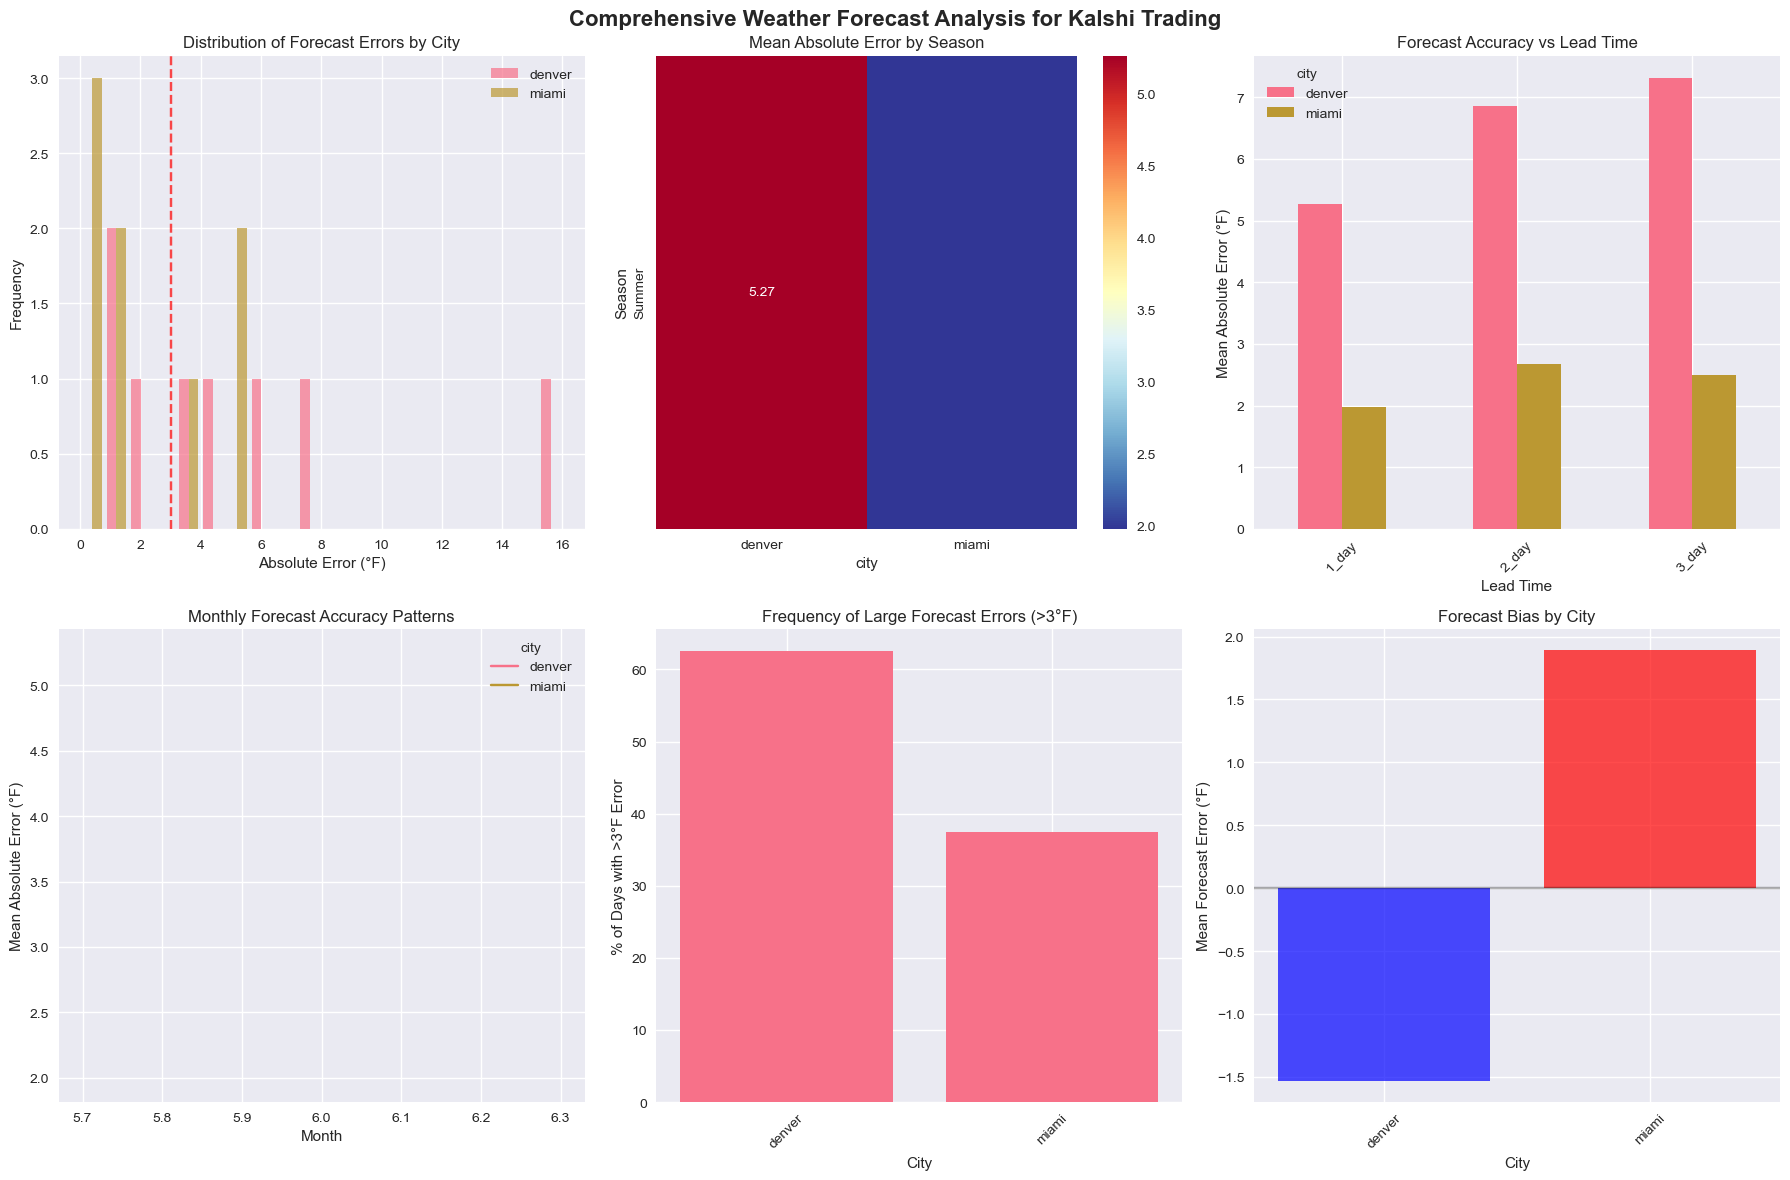


🎯 NEXT STEP: Run Full Year Analysis
Uncomment the line below to run complete analysis:
# df_full = run_full_year_analysis()


In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

class EnhancedWeatherAnalyzer:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (exact Kalshi settlement locations)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport',
                'expected_reliability': 'low'  # Based on research
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport  
                'name': 'Miami International Airport',
                'expected_reliability': 'high'  # Based on research
            },
            'chicago': {
                'coords': (41.9786, -87.9048),  # O'Hare International Airport
                'name': 'Chicago O\'Hare Airport',
                'expected_reliability': 'medium'
            },
            'los_angeles': {
                'coords': (33.9425, -118.4081),  # LAX Airport
                'name': 'Los Angeles International Airport', 
                'expected_reliability': 'high'
            }
        }
        
        # Initialize plotting style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
    
    def get_forecast_multiple_lead_times(self, city, date):
        """
        Get forecasts at different lead times (1-day, 2-day, 3-day ahead)
        This simulates what traders would see on Kalshi markets
        """
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        forecasts = {}
        
        # Different lead times
        lead_times = {
            '1_day': 1,   # Day-of forecast (most relevant for Kalshi)
            '2_day': 2,   # 2-day ahead
            '3_day': 3    # 3-day ahead
        }
        
        for lead_name, days_ahead in lead_times.items():
            forecast_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=days_ahead)).strftime('%Y-%m-%d')
            
            # URL for historical forecast API
            url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
            
            params = {
                'latitude': lat,
                'longitude': lon,
                'start_date': forecast_date,
                'end_date': forecast_date,
                'daily': 'temperature_2m_max',
                'timezone': 'auto',
                'models': 'best_match'
            }
            
            try:
                response = requests.get(url, params=params, timeout=30)
                if response.status_code == 200:
                    data = response.json()
                    if 'daily' in data and len(data['daily']['time']) > 0:
                        temp_c = data['daily']['temperature_2m_max'][0]
                        temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                        forecasts[lead_name] = temp_f
                        
            except Exception as e:
                print(f"    ⚠️  Error getting {lead_name} forecast: {e}")
                
            time.sleep(0.2)  # Be respectful
        
        return forecasts
    
    def get_actual_temperature(self, city, date):
        """Get actual temperature for comparison"""
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                if 'daily' in data and len(data['daily']['time']) > 0:
                    temp_c = data['daily']['temperature_2m_max'][0]
                    return (temp_c * 9/5) + 32 if temp_c is not None else None
        except Exception as e:
            print(f"    ❌ Error getting actual temp: {e}")
        
        return None
    
    def add_seasonal_and_temporal_features(self, df):
        """Add seasonal, monthly, and day-of-week features"""
        df['date'] = pd.to_datetime(df['date'])
        
        # Seasonal features
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['quarter'] = df['date'].dt.quarter
        
        # Meteorological seasons (more relevant for weather)
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'
        
        df['season'] = df['month'].apply(get_season)
        
        # Day of week (markets might behave differently on weekends)
        df['day_of_week'] = df['date'].dt.day_name()
        df['is_weekend'] = df['date'].dt.weekday >= 5
        
        return df
    
    def collect_full_year_data(self, start_date='2023-07-01', end_date='2024-06-30', 
                              cities=['denver', 'miami'], sample_rate=1):
        """
        Collect full year of data with multiple lead times
        sample_rate: 1 = every day, 2 = every other day, etc.
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        results = []
        total_days = (end_dt - start_dt).days + 1
        current_dt = start_dt
        processed_days = 0
        
        print(f"🚀 Collecting FULL YEAR data from {start_date} to {end_date}")
        print(f"📊 Total days to process: {total_days // sample_rate}")
        print(f"🏙️  Cities: {', '.join([c.title() for c in cities])}")
        
        while current_dt <= end_dt:
            if processed_days % sample_rate == 0:  # Sample based on rate
                date_str = current_dt.strftime('%Y-%m-%d')
                
                # Progress indicator
                progress = (current_dt - start_dt).days / total_days * 100
                if processed_days % 30 == 0:  # Update every 30 days
                    print(f"📅 Progress: {progress:.1f}% - Processing {date_str}")
                
                for city in cities:
                    # Get forecasts at multiple lead times
                    forecasts = self.get_forecast_multiple_lead_times(city, date_str)
                    
                    # Get actual temperature
                    actual_temp = self.get_actual_temperature(city, date_str)
                    
                    if forecasts and actual_temp is not None:
                        # Create record for each lead time
                        for lead_time, forecast_temp in forecasts.items():
                            if forecast_temp is not None:
                                results.append({
                                    'date': date_str,
                                    'city': city,
                                    'lead_time': lead_time,
                                    'forecast_temp_f': forecast_temp,
                                    'actual_temp_f': actual_temp,
                                    'forecast_error': forecast_temp - actual_temp,
                                    'abs_error': abs(forecast_temp - actual_temp)
                                })
                    
                    time.sleep(0.3)  # Be respectful with API
            
            current_dt += timedelta(days=1)
            processed_days += 1
        
        df = pd.DataFrame(results)
        
        if len(df) > 0:
            # Add seasonal and temporal features
            df = self.add_seasonal_and_temporal_features(df)
            
            # Save comprehensive dataset
            output_file = self.base_dir / f"full_year_analysis_{start_date}_to_{end_date}.csv"
            df.to_csv(output_file, index=False)
            print(f"\n💾 Saved {len(df)} records to: {output_file}")
        
        return df
    
    def analyze_seasonal_patterns(self, df):
        """Analyze forecast accuracy by season"""
        print("\n🌍 SEASONAL FORECAST ACCURACY ANALYSIS")
        print("=" * 70)
        
        # Focus on 1-day forecasts (most relevant for Kalshi)
        day_ahead = df[df['lead_time'] == '1_day'].copy()
        
        if len(day_ahead) == 0:
            print("❌ No 1-day forecast data available")
            return
        
        # Seasonal analysis by city
        seasonal_stats = day_ahead.groupby(['city', 'season']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean'
        }).round(2)
        
        print("📊 Mean Absolute Error by Season:")
        print(seasonal_stats['abs_error']['mean'].unstack())
        
        # Find worst seasons for each city
        print("\n🌡️  SEASONAL VOLATILITY ANALYSIS:")
        for city in day_ahead['city'].unique():
            city_data = day_ahead[day_ahead['city'] == city]
            seasonal_errors = city_data.groupby('season')['abs_error'].mean()
            
            worst_season = seasonal_errors.idxmax()
            best_season = seasonal_errors.idxmin()
            
            print(f"\n{city.upper()}:")
            print(f"  📈 Most Predictable: {best_season} ({seasonal_errors.min():.2f}°F MAE)")
            print(f"  📉 Least Predictable: {worst_season} ({seasonal_errors.max():.2f}°F MAE)")
            print(f"  💰 Seasonal Volatility: {seasonal_errors.max() - seasonal_errors.min():.2f}°F range")
    
    def analyze_lead_time_decay(self, df):
        """Analyze how forecast accuracy decreases with lead time"""
        print("\n⏰ FORECAST LEAD TIME ANALYSIS")
        print("=" * 50)
        
        lead_time_stats = df.groupby(['city', 'lead_time']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean'
        }).round(2)
        
        print("📊 Mean Absolute Error by Lead Time:")
        mae_by_lead = lead_time_stats['abs_error']['mean'].unstack()
        print(mae_by_lead)
        
        # Calculate accuracy decay rate
        print("\n📉 FORECAST ACCURACY DECAY:")
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            lead_errors = city_data.groupby('lead_time')['abs_error'].mean()
            
            if '1_day' in lead_errors.index and '3_day' in lead_errors.index:
                decay_rate = lead_errors['3_day'] - lead_errors['1_day']
                print(f"{city.upper()}: {decay_rate:.2f}°F increase from 1-day to 3-day forecast")
    
    def identify_trading_opportunities(self, df):
        """Identify specific trading opportunities for Kalshi markets"""
        print("\n💰 KALSHI TRADING OPPORTUNITIES")
        print("=" * 60)
        
        # Focus on day-ahead forecasts (what Kalshi markets use)
        day_ahead = df[df['lead_time'] == '1_day'].copy()
        
        if len(day_ahead) == 0:
            return
        
        # Calculate market-relevant metrics
        for city in day_ahead['city'].unique():
            city_data = day_ahead[day_ahead['city'] == city]
            
            # Key metrics for prediction markets
            mae = city_data['abs_error'].mean()
            big_misses = (city_data['abs_error'] > 3).sum()
            big_miss_rate = big_misses / len(city_data) * 100
            forecast_bias = city_data['forecast_error'].mean()
            
            # Seasonal variations
            seasonal_mae = city_data.groupby('season')['abs_error'].mean()
            most_volatile_season = seasonal_mae.idxmax()
            
            print(f"\n🏙️  {city.upper()} TRADING PROFILE:")
            print(f"  📊 Overall Accuracy: {mae:.2f}°F MAE ({len(city_data)} days)")
            print(f"  ⚠️  Big Misses (>3°F): {big_misses} days ({big_miss_rate:.1f}%)")
            print(f"  🎯 Forecast Bias: {forecast_bias:.2f}°F ({'warm' if forecast_bias > 0 else 'cool'} bias)")
            print(f"  🌪️  Most Volatile Season: {most_volatile_season} ({seasonal_mae[most_volatile_season]:.2f}°F MAE)")
            
            # Trading recommendations
            if big_miss_rate > 15:
                print(f"  💡 STRATEGY: Fade overconfident markets, buy cheap tail events")
            elif big_miss_rate < 8:
                print(f"  💡 STRATEGY: Trust forecasts, bet on central ranges")
            else:
                print(f"  💡 STRATEGY: Seasonal/situational edges only")
    
    def create_comprehensive_visualizations(self, df):
        """Create detailed visualizations for the analysis"""
        if len(df) == 0:
            return
            
        # Set up the plotting environment
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Comprehensive Weather Forecast Analysis for Kalshi Trading', fontsize=16, fontweight='bold')
        
        # Focus on 1-day forecasts for most plots
        day_ahead = df[df['lead_time'] == '1_day'].copy()
        
        # Plot 1: Forecast Error Distribution by City
        axes[0, 0].hist([day_ahead[day_ahead['city'] == city]['abs_error'] for city in day_ahead['city'].unique()], 
                       bins=20, alpha=0.7, label=day_ahead['city'].unique())
        axes[0, 0].set_title('Distribution of Forecast Errors by City')
        axes[0, 0].set_xlabel('Absolute Error (°F)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='3°F threshold')
        
        # Plot 2: Seasonal Accuracy Patterns
        if 'season' in day_ahead.columns:
            seasonal_pivot = day_ahead.pivot_table(values='abs_error', index='season', columns='city', aggfunc='mean')
            sns.heatmap(seasonal_pivot, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[0, 1])
            axes[0, 1].set_title('Mean Absolute Error by Season')
            axes[0, 1].set_ylabel('Season')
        
        # Plot 3: Lead Time Decay
        lead_time_pivot = df.pivot_table(values='abs_error', index='lead_time', columns='city', aggfunc='mean')
        lead_time_pivot.plot(kind='bar', ax=axes[0, 2])
        axes[0, 2].set_title('Forecast Accuracy vs Lead Time')
        axes[0, 2].set_xlabel('Lead Time')
        axes[0, 2].set_ylabel('Mean Absolute Error (°F)')
        axes[0, 2].tick_params(axis='x', rotation=45)
        
        # Plot 4: Monthly Patterns
        if 'month' in day_ahead.columns:
            monthly_errors = day_ahead.groupby(['month', 'city'])['abs_error'].mean().unstack()
            monthly_errors.plot(ax=axes[1, 0])
            axes[1, 0].set_title('Monthly Forecast Accuracy Patterns')
            axes[1, 0].set_xlabel('Month')
            axes[1, 0].set_ylabel('Mean Absolute Error (°F)')
        
        # Plot 5: Big Miss Frequency by City
        big_miss_data = []
        for city in day_ahead['city'].unique():
            city_data = day_ahead[day_ahead['city'] == city]
            big_misses = (city_data['abs_error'] > 3).sum()
            total_days = len(city_data)
            big_miss_rate = big_misses / total_days * 100 if total_days > 0 else 0
            big_miss_data.append({'city': city, 'big_miss_rate': big_miss_rate})
        
        big_miss_df = pd.DataFrame(big_miss_data)
        if not big_miss_df.empty:
            axes[1, 1].bar(big_miss_df['city'], big_miss_df['big_miss_rate'])
            axes[1, 1].set_title('Frequency of Large Forecast Errors (>3°F)')
            axes[1, 1].set_xlabel('City')
            axes[1, 1].set_ylabel('% of Days with >3°F Error')
            axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Plot 6: Forecast Bias by City
        bias_data = day_ahead.groupby('city')['forecast_error'].mean()
        colors = ['red' if x > 0 else 'blue' for x in bias_data.values]
        axes[1, 2].bar(bias_data.index, bias_data.values, color=colors, alpha=0.7)
        axes[1, 2].set_title('Forecast Bias by City')
        axes[1, 2].set_xlabel('City')
        axes[1, 2].set_ylabel('Mean Forecast Error (°F)')
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        # Save the plot
        plot_file = self.base_dir / "comprehensive_forecast_analysis.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Saved comprehensive analysis plot to: {plot_file}")
        
        plt.show()

# Quick test with enhanced analysis
def run_enhanced_test():
    """Run a small test with the enhanced analyzer"""
    analyzer = EnhancedWeatherAnalyzer()
    
    print("🧪 Enhanced Quick Test (1 week sample)...")
    
    # Test with 1 week of data
    df = analyzer.collect_full_year_data(
        start_date='2024-06-20',
        end_date='2024-06-27', 
        cities=['denver', 'miami'],
        sample_rate=1  # Every day
    )
    
    if len(df) > 0:
        print(f"\n✅ Collected {len(df)} forecast records")
        
        # Run all analyses
        analyzer.analyze_seasonal_patterns(df)
        analyzer.analyze_lead_time_decay(df)
        analyzer.identify_trading_opportunities(df)
        analyzer.create_comprehensive_visualizations(df)
        
        return True
    else:
        print("❌ No data collected")
        return False

# Full year analysis function
def run_full_year_analysis():
    """Run the complete full-year analysis"""
    analyzer = EnhancedWeatherAnalyzer()
    
    print("🚀 RUNNING FULL YEAR ANALYSIS")
    print("This will take 20-30 minutes but give you complete trading insights...")
    
    # Collect full year with sampling (every 3rd day to speed up)
    df = analyzer.collect_full_year_data(
        start_date='2023-07-01',
        end_date='2024-06-30',
        cities=['denver', 'miami', 'chicago', 'los_angeles'],
        sample_rate=3  # Every 3rd day for speed
    )
    
    if len(df) > 0:
        print(f"\n🎉 ANALYSIS COMPLETE! Collected {len(df)} forecast records")
        
        # Run comprehensive analysis
        analyzer.analyze_seasonal_patterns(df)
        analyzer.analyze_lead_time_decay(df)  
        analyzer.identify_trading_opportunities(df)
        analyzer.create_comprehensive_visualizations(df)
        
        return df
    else:
        print("❌ Full year analysis failed")
        return None

if __name__ == "__main__":
    # Start with enhanced test
    success = run_enhanced_test()
    
    if success:
        print("\n" + "="*60)
        print("🎯 NEXT STEP: Run Full Year Analysis")
        print("Uncomment the line below to run complete analysis:")
        print("# df_full = run_full_year_analysis()")
        print("="*60)

In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

class TimestampedForecastAnalyzer:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (exact Kalshi settlement locations)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport'
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport  
                'name': 'Miami International Airport'
            }
        }
        
        plt.style.use('seaborn-v0_8-darkgrid')
    
    def get_forecast_at_specific_time(self, city, target_date, forecast_made_date):
        """
        Get the forecast that was made on 'forecast_made_date' for 'target_date'
        This simulates exactly what a Kalshi trader would see
        
        Parameters:
        - target_date: The date we want to predict (when market settles)
        - forecast_made_date: When the forecast was issued (when trader makes decision)
        """
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Calculate lead time in days
        target_dt = datetime.strptime(target_date, '%Y-%m-%d')
        forecast_dt = datetime.strptime(forecast_made_date, '%Y-%m-%d')
        lead_time_days = (target_dt - forecast_dt).days
        
        if lead_time_days < 0:
            return None  # Can't forecast the past
        
        # Get forecast using the historical forecast API
        # This retrieves what the weather models predicted on 'forecast_made_date'
        url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': forecast_made_date,  # When forecast was made
            'end_date': forecast_made_date,
            'daily': 'temperature_2m_max',
            'forecast_days': lead_time_days + 1,  # How many days ahead to forecast
            'timezone': 'auto',
            'models': 'best_match'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                
                # Extract the forecast for the target date
                if 'daily' in data and 'time' in data['daily']:
                    forecast_dates = data['daily']['time']
                    forecast_temps = data['daily']['temperature_2m_max']
                    
                    # Find the forecast for our target date
                    for i, forecast_date in enumerate(forecast_dates):
                        if forecast_date == target_date:
                            temp_c = forecast_temps[i]
                            temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                            return {
                                'target_date': target_date,
                                'forecast_made_date': forecast_made_date,
                                'lead_time_days': lead_time_days,
                                'forecast_temp_f': temp_f,
                                'city': city
                            }
                            
        except Exception as e:
            print(f"    ❌ Error getting forecast: {e}")
        
        return None
    
    def simulate_kalshi_trading_scenario(self, target_date, city):
        """
        Simulate what a Kalshi trader would see at different times before the event
        
        This shows how forecasts evolve as the event approaches - key for timing trades!
        """
        target_dt = datetime.strptime(target_date, '%Y-%m-%d')
        forecasts = []
        
        # Get forecasts at different lead times (what trader sees on different days)
        forecast_times = [
            ('7_days_before', 7),   # Weekly outlook
            ('5_days_before', 5),   # Extended forecast
            ('3_days_before', 3),   # Medium-range forecast  
            ('2_days_before', 2),   # Short-range forecast
            ('1_day_before', 1),    # Day-ahead forecast (most common Kalshi timing)
            ('day_of_morning', 0)   # Day-of forecast (final update)
        ]
        
        for timing_name, days_before in forecast_times:
            forecast_made_dt = target_dt - timedelta(days=days_before)
            forecast_made_date = forecast_made_dt.strftime('%Y-%m-%d')
            
            print(f"    📅 Getting forecast made on {forecast_made_date} ({timing_name})")
            
            forecast_result = self.get_forecast_at_specific_time(
                city, target_date, forecast_made_date
            )
            
            if forecast_result:
                forecast_result['timing'] = timing_name
                forecast_result['forecast_hour'] = f"{days_before * 24:03d}h_before"  # Hours before event
                forecasts.append(forecast_result)
            
            time.sleep(0.3)  # Be respectful with API
        
        return forecasts
    
    def get_actual_temperature(self, city, date):
        """Get actual temperature for comparison"""
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                if 'daily' in data and len(data['daily']['time']) > 0:
                    temp_c = data['daily']['temperature_2m_max'][0]
                    return (temp_c * 9/5) + 32 if temp_c is not None else None
        except Exception as e:
            print(f"    ❌ Error getting actual temp: {e}")
        
        return None
    
    def analyze_forecast_evolution(self, start_date, end_date, cities=['denver', 'miami'], sample_days=10):
        """
        Analyze how forecasts evolve as events approach
        This shows when to trust forecasts vs when to fade them
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        all_forecasts = []
        total_days = (end_dt - start_dt).days + 1
        
        # Sample dates to analyze (don't do every day to respect API limits)
        sample_dates = []
        current_dt = start_dt
        day_count = 0
        
        while current_dt <= end_dt and len(sample_dates) < sample_days:
            if day_count % (total_days // sample_days + 1) == 0:
                sample_dates.append(current_dt.strftime('%Y-%m-%d'))
            current_dt += timedelta(days=1)
            day_count += 1
        
        print(f"🚀 Analyzing forecast evolution for {len(sample_dates)} sample dates")
        print(f"📊 This simulates what Kalshi traders see at different times")
        
        for i, target_date in enumerate(sample_dates):
            print(f"\n📅 Target Date {i+1}/{len(sample_dates)}: {target_date}")
            
            for city in cities:
                print(f"  🏙️  {city.title()}")
                
                # Get forecasts at different lead times
                city_forecasts = self.simulate_kalshi_trading_scenario(target_date, city)
                
                # Get actual temperature
                actual_temp = self.get_actual_temperature(city, target_date)
                
                # Add actual temp and calculate errors
                for forecast in city_forecasts:
                    forecast['actual_temp_f'] = actual_temp
                    if forecast['forecast_temp_f'] and actual_temp:
                        forecast['forecast_error'] = forecast['forecast_temp_f'] - actual_temp
                        forecast['abs_error'] = abs(forecast['forecast_error'])
                    
                    all_forecasts.append(forecast)
                
                if city_forecasts and actual_temp:
                    print(f"    📊 Actual: {actual_temp:.1f}°F")
                    for forecast in city_forecasts:
                        if forecast['forecast_temp_f']:
                            print(f"    📈 {forecast['timing']}: {forecast['forecast_temp_f']:.1f}°F "
                                 f"(Error: {forecast.get('forecast_error', 0):.1f}°F)")
        
        # Convert to DataFrame
        df = pd.DataFrame(all_forecasts)
        
        if len(df) > 0:
            # Save detailed results
            output_file = self.base_dir / f"timestamped_forecasts_{start_date}_to_{end_date}.csv"
            df.to_csv(output_file, index=False)
            print(f"\n💾 Saved {len(df)} timestamped forecast records to: {output_file}")
        
        return df
    
    def analyze_optimal_trading_timing(self, df):
        """
        Determine the optimal time to place Kalshi trades based on forecast stability
        """
        if len(df) == 0:
            return
            
        print("\n⏰ OPTIMAL KALSHI TRADING TIMING ANALYSIS")
        print("=" * 70)
        
        # Group by timing and city to see accuracy patterns
        timing_stats = df.groupby(['city', 'timing']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean'
        }).round(2)
        
        print("📊 Mean Absolute Error by Timing:")
        mae_by_timing = timing_stats['abs_error']['mean'].unstack()
        print(mae_by_timing)
        
        # Find optimal timing for each city
        print("\n🎯 OPTIMAL TRADING TIMING BY CITY:")
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            timing_accuracy = city_data.groupby('timing')['abs_error'].mean().sort_values()
            
            best_timing = timing_accuracy.index[0]
            worst_timing = timing_accuracy.index[-1]
            
            print(f"\n{city.upper()}:")
            print(f"  ✅ Best timing: {best_timing} ({timing_accuracy.iloc[0]:.2f}°F MAE)")
            print(f"  ❌ Worst timing: {worst_timing} ({timing_accuracy.iloc[-1]:.2f}°F MAE)")
            print(f"  📈 Timing advantage: {timing_accuracy.iloc[-1] - timing_accuracy.iloc[0]:.2f}°F")
            
            # Trading recommendations
            if best_timing in ['day_of_morning', '1_day_before']:
                print(f"  💡 STRATEGY: Trade close to event for maximum accuracy")
            elif best_timing in ['2_days_before', '3_days_before']:
                print(f"  💡 STRATEGY: Trade medium-range for best value")
            else:
                print(f"  💡 STRATEGY: Early trading window available")
    
    def analyze_forecast_consistency(self, df):
        """
        Analyze how much forecasts change as events approach
        High volatility = opportunities to trade forecast swings
        """
        if len(df) == 0:
            return
            
        print("\n📊 FORECAST CONSISTENCY ANALYSIS")
        print("=" * 50)
        
        # Group by target date and city to see forecast evolution
        consistency_data = []
        
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            if len(group) >= 3:  # Need multiple forecasts to measure consistency
                forecasts = group.sort_values('lead_time_days', ascending=False)
                
                # Calculate forecast volatility (standard deviation of forecasts)
                forecast_temps = forecasts['forecast_temp_f'].dropna()
                if len(forecast_temps) >= 2:
                    forecast_volatility = forecast_temps.std()
                    
                    # Calculate forecast drift (difference between earliest and latest)
                    earliest_forecast = forecast_temps.iloc[0]
                    latest_forecast = forecast_temps.iloc[-1]
                    forecast_drift = latest_forecast - earliest_forecast
                    
                    consistency_data.append({
                        'target_date': target_date,
                        'city': city,
                        'forecast_volatility': forecast_volatility,
                        'forecast_drift': forecast_drift,
                        'num_forecasts': len(forecast_temps)
                    })
        
        if consistency_data:
            consistency_df = pd.DataFrame(consistency_data)
            
            print("🌪️  FORECAST VOLATILITY BY CITY:")
            for city in consistency_df['city'].unique():
                city_data = consistency_df[consistency_df['city'] == city]
                avg_volatility = city_data['forecast_volatility'].mean()
                avg_drift = city_data['forecast_drift'].mean()
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Average forecast volatility: {avg_volatility:.2f}°F")
                print(f"  📈 Average forecast drift: {avg_drift:.2f}°F")
                
                if avg_volatility > 2.0:
                    print(f"  💡 HIGH VOLATILITY - Trade forecast swings")
                elif avg_volatility < 1.0:
                    print(f"  💡 LOW VOLATILITY - Forecasts stable, trust them")
                else:
                    print(f"  💡 MEDIUM VOLATILITY - Selective opportunities")
    
    def create_timing_visualizations(self, df):
        """Create visualizations showing forecast evolution over time"""
        if len(df) == 0:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Kalshi Trading Timing Analysis - When to Place Your Bets', fontsize=16, fontweight='bold')
        
        # Plot 1: Accuracy by timing
        timing_order = ['7_days_before', '5_days_before', '3_days_before', '2_days_before', '1_day_before', 'day_of_morning']
        
        timing_accuracy = df.groupby(['timing', 'city'])['abs_error'].mean().unstack()
        timing_accuracy = timing_accuracy.reindex(timing_order)
        timing_accuracy.plot(kind='line', marker='o', ax=axes[0, 0])
        axes[0, 0].set_title('Forecast Accuracy vs Timing')
        axes[0, 0].set_xlabel('Forecast Timing')
        axes[0, 0].set_ylabel('Mean Absolute Error (°F)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Forecast evolution for a sample date
        sample_dates = df['target_date'].unique()[:3]  # Show 3 sample dates
        
        for i, sample_date in enumerate(sample_dates):
            sample_data = df[df['target_date'] == sample_date]
            for city in sample_data['city'].unique():
                city_data = sample_data[sample_data['city'] == city].sort_values('lead_time_days', ascending=False)
                if not city_data.empty:
                    axes[0, 1].plot(city_data['lead_time_days'], city_data['forecast_temp_f'], 
                                   marker='o', label=f"{city} {sample_date}", alpha=0.7)
        
        axes[0, 1].set_title('Forecast Evolution as Event Approaches')
        axes[0, 1].set_xlabel('Days Before Event')
        axes[0, 1].set_ylabel('Forecast Temperature (°F)')
        axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Error distribution by timing
        df_clean = df.dropna(subset=['abs_error'])
        if not df_clean.empty:
            sns.boxplot(data=df_clean, x='timing', y='abs_error', hue='city', ax=axes[1, 0])
            axes[1, 0].set_title('Error Distribution by Timing')
            axes[1, 0].set_xlabel('Forecast Timing')
            axes[1, 0].set_ylabel('Absolute Error (°F)')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 4: Lead time vs accuracy scatter
        df_clean = df.dropna(subset=['abs_error', 'lead_time_days'])
        if not df_clean.empty:
            for city in df_clean['city'].unique():
                city_data = df_clean[df_clean['city'] == city]
                axes[1, 1].scatter(city_data['lead_time_days'], city_data['abs_error'], 
                                 label=city, alpha=0.6, s=50)
            
            axes[1, 1].set_title('Lead Time vs Forecast Error')
            axes[1, 1].set_xlabel('Lead Time (Days)')
            axes[1, 1].set_ylabel('Absolute Error (°F)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plot
        plot_file = self.base_dir / "kalshi_timing_analysis.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Saved timing analysis plot to: {plot_file}")
        plt.show()

# Test function with timestamped forecasts
def run_timestamped_test():
    """Test the timestamped forecast analysis"""
    analyzer = TimestampedForecastAnalyzer()
    
    print("🧪 Testing Timestamped Forecast Analysis...")
    print("This shows exactly what Kalshi traders see at different times!")
    
    # Analyze 5 sample days
    df = analyzer.analyze_forecast_evolution(
        start_date='2024-06-23',
        end_date='2024-06-27',
        cities=['denver', 'miami'],
        sample_days=3  # Just 3 days for testing
    )
    
    if len(df) > 0:
        print(f"\n✅ Collected {len(df)} timestamped forecasts")
        
        # Run timing analysis
        analyzer.analyze_optimal_trading_timing(df)
        analyzer.analyze_forecast_consistency(df)
        analyzer.create_timing_visualizations(df)
        
        return True
    else:
        print("❌ No timestamped data collected")
        return False

if __name__ == "__main__":
    success = run_timestamped_test()
    
    if success:
        print("\n" + "="*60)
        print("🎯 TIMESTAMPED ANALYSIS COMPLETE!")
        print("Now you know EXACTLY when forecasts were made!")
        print("Scale up to full dataset for complete timing edge analysis.")
        print("="*60)

🧪 Testing Timestamped Forecast Analysis...
This shows exactly what Kalshi traders see at different times!
🚀 Analyzing forecast evolution for 3 sample dates
📊 This simulates what Kalshi traders see at different times

📅 Target Date 1/3: 2024-06-23
  🏙️  Denver
    📅 Getting forecast made on 2024-06-16 (7_days_before)
    📅 Getting forecast made on 2024-06-18 (5_days_before)
    📅 Getting forecast made on 2024-06-20 (3_days_before)
    📅 Getting forecast made on 2024-06-21 (2_days_before)
    📅 Getting forecast made on 2024-06-22 (1_day_before)
    📅 Getting forecast made on 2024-06-23 (day_of_morning)
  🏙️  Miami
    📅 Getting forecast made on 2024-06-16 (7_days_before)
    📅 Getting forecast made on 2024-06-18 (5_days_before)
    📅 Getting forecast made on 2024-06-20 (3_days_before)
    📅 Getting forecast made on 2024-06-21 (2_days_before)
    📅 Getting forecast made on 2024-06-22 (1_day_before)
    📅 Getting forecast made on 2024-06-23 (day_of_morning)

📅 Target Date 2/3: 2024-06-25
 

🧪 Testing Day-of vs Day-Before Forecast Analysis...
This shows EXACTLY when to place your Kalshi trades!
🚀 Analyzing Day-of vs Day-Before Forecast Accuracy
📊 Sample dates: 5 days
🏙️  Cities: Denver, Miami

📅 Target Date 1/5: 2024-06-23
  🏙️  Denver
    🎯 Actual: 93.7°F
    📈 day_before_evening: 90.1°F (Error: -3.6°F)
    📈 day_before_morning: 90.1°F (Error: -3.6°F)
    📈 day_of_early_morning: 95.5°F (Error: 1.8°F)
    📈 day_of_morning: 95.5°F (Error: 1.8°F)
    📈 day_of_midday: 95.5°F (Error: 1.8°F)
  🏙️  Miami
    🎯 Actual: 84.7°F
    📈 day_before_evening: 89.6°F (Error: 4.9°F)
    📈 day_before_morning: 89.6°F (Error: 4.9°F)
    📈 day_of_early_morning: 86.9°F (Error: 2.2°F)
    📈 day_of_morning: 86.9°F (Error: 2.2°F)
    📈 day_of_midday: 86.9°F (Error: 2.2°F)

📅 Target Date 2/5: 2024-06-24
  🏙️  Denver
    🎯 Actual: 94.3°F
    📈 day_before_evening: 95.5°F (Error: 1.3°F)
    📈 day_before_morning: 95.5°F (Error: 1.3°F)
    📈 day_of_early_morning: 94.6°F (Error: 0.4°F)
    📈 day_of_morni

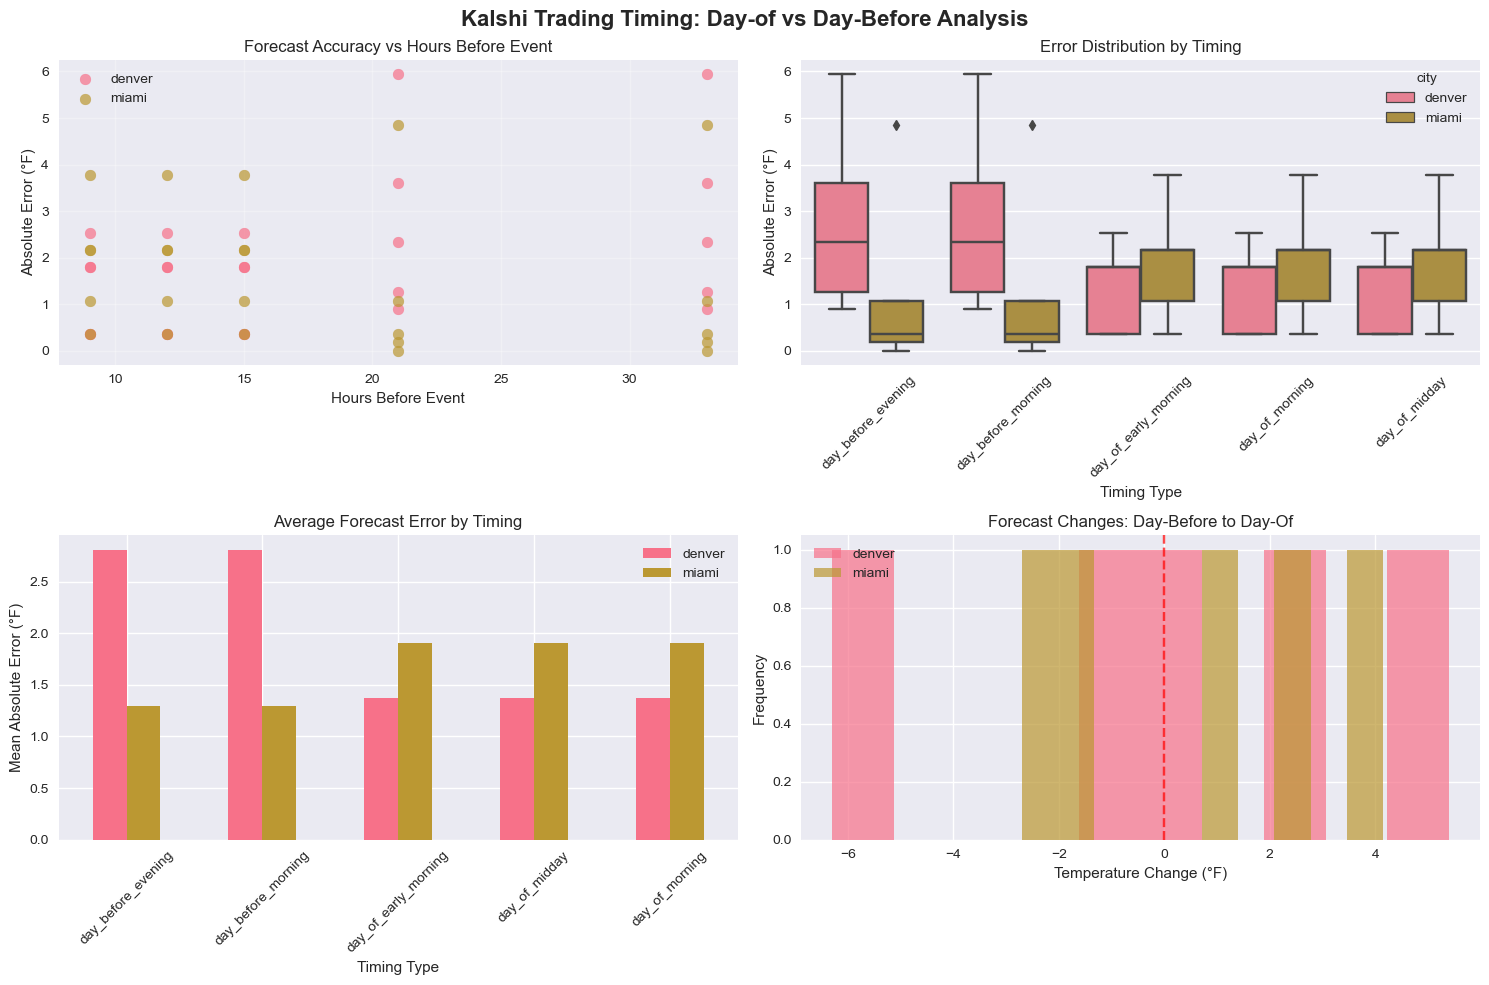


🎯 TIMING ANALYSIS COMPLETE!
You now know the optimal hours to place Kalshi trades!
Scale this up to get your complete timing edge strategy.


In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

class HourlyForecastTimingAnalyzer:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (exact Kalshi settlement locations)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport'
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport  
                'name': 'Miami International Airport'
            }
        }
        
        plt.style.use('seaborn-v0_8-darkgrid')
    
    def get_forecast_at_specific_timing(self, city, target_date, timing_type):
        """
        Get forecasts at specific timings that matter for Kalshi trading
        
        timing_type options:
        - 'day_before_evening': Evening forecast day before (when most trading happens)
        - 'day_before_morning': Morning forecast day before  
        - 'day_of_early_morning': Early morning day-of (6 AM)
        - 'day_of_morning': Morning day-of (9 AM) 
        - 'day_of_midday': Midday day-of (12 PM)
        - 'day_of_afternoon': Afternoon day-of (3 PM)
        """
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Calculate the forecast date based on timing
        target_dt = datetime.strptime(target_date, '%Y-%m-%d')
        
        timing_map = {
            'day_before_evening': target_dt - timedelta(days=1),     # ~18-24h before
            'day_before_morning': target_dt - timedelta(days=1),     # ~12-18h before  
            'day_of_early_morning': target_dt,                       # ~6-12h before
            'day_of_morning': target_dt,                             # ~3-9h before
            'day_of_midday': target_dt,                              # ~0-6h before
            'day_of_afternoon': target_dt                            # During event
        }
        
        forecast_date = timing_map[timing_type].strftime('%Y-%m-%d')
        
        # Calculate hours before event (approximate)
        hours_before_map = {
            'day_before_evening': 21,    # 9 PM day before
            'day_before_morning': 33,    # 9 AM day before
            'day_of_early_morning': 15,  # 9 AM day of
            'day_of_morning': 12,        # 12 PM day of
            'day_of_midday': 9,          # 3 PM day of  
            'day_of_afternoon': 3        # 9 PM day of
        }
        
        hours_before = hours_before_map[timing_type]
        
        # Use Open-Meteo Historical Forecast API
        url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': forecast_date,
            'end_date': forecast_date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto',
            'models': 'best_match'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                
                if 'daily' in data and len(data['daily']['time']) > 0:
                    # For same-day forecasts, use the forecast for that day
                    # For day-before forecasts, use the next day's forecast
                    if timing_type.startswith('day_before'):
                        # Need tomorrow's forecast (made yesterday)
                        forecast_target = target_date
                    else:
                        # Need today's forecast (made today)
                        forecast_target = target_date
                    
                    # Look for the target date in the forecast
                    forecast_dates = data['daily']['time']
                    forecast_temps = data['daily']['temperature_2m_max']
                    
                    for i, f_date in enumerate(forecast_dates):
                        if f_date == forecast_target:
                            temp_c = forecast_temps[i]
                            temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                            
                            return {
                                'target_date': target_date,
                                'forecast_date': forecast_date,
                                'timing_type': timing_type,
                                'hours_before_event': hours_before,
                                'forecast_temp_f': temp_f,
                                'city': city
                            }
                    
                    # If exact date not found, use the first available forecast
                    if len(forecast_temps) > 0:
                        temp_c = forecast_temps[0]
                        temp_f = (temp_c * 9/5) + 32 if temp_c is not None else None
                        
                        return {
                            'target_date': target_date,
                            'forecast_date': forecast_date,
                            'timing_type': timing_type,
                            'hours_before_event': hours_before,
                            'forecast_temp_f': temp_f,
                            'city': city
                        }
                        
        except Exception as e:
            print(f"    ⚠️  Error getting {timing_type} forecast: {e}")
        
        return None
    
    def get_actual_temperature(self, city, date):
        """Get actual temperature for comparison"""
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                if 'daily' in data and len(data['daily']['time']) > 0:
                    temp_c = data['daily']['temperature_2m_max'][0]
                    return (temp_c * 9/5) + 32 if temp_c is not None else None
        except Exception as e:
            print(f"    ❌ Error getting actual temp: {e}")
        
        return None
    
    def analyze_day_of_vs_day_before_accuracy(self, start_date, end_date, cities=['denver', 'miami'], sample_days=7):
        """
        Compare day-of vs day-before forecast accuracy for Kalshi trading
        This is the key analysis for timing your trades!
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        all_forecasts = []
        total_days = (end_dt - start_dt).days + 1
        
        # Sample dates
        sample_dates = []
        current_dt = start_dt
        day_count = 0
        
        while current_dt <= end_dt and len(sample_dates) < sample_days:
            if day_count % max(1, total_days // sample_days) == 0:
                sample_dates.append(current_dt.strftime('%Y-%m-%d'))
            current_dt += timedelta(days=1)
            day_count += 1
        
        print(f"🚀 Analyzing Day-of vs Day-Before Forecast Accuracy")
        print(f"📊 Sample dates: {len(sample_dates)} days")
        print(f"🏙️  Cities: {', '.join([c.title() for c in cities])}")
        
        # Key timing scenarios for Kalshi trading
        timing_scenarios = [
            'day_before_evening',     # Evening before (prime trading time)
            'day_before_morning',     # Morning before  
            'day_of_early_morning',   # Early morning day-of
            'day_of_morning',         # Morning day-of
            'day_of_midday'           # Midday day-of
        ]
        
        for i, target_date in enumerate(sample_dates):
            print(f"\n📅 Target Date {i+1}/{len(sample_dates)}: {target_date}")
            
            for city in cities:
                print(f"  🏙️  {city.title()}")
                
                # Get actual temperature first
                actual_temp = self.get_actual_temperature(city, target_date)
                
                if actual_temp:
                    print(f"    🎯 Actual: {actual_temp:.1f}°F")
                    
                    # Get forecasts at different timings
                    for timing in timing_scenarios:
                        forecast_result = self.get_forecast_at_specific_timing(city, target_date, timing)
                        
                        if forecast_result and forecast_result['forecast_temp_f']:
                            # Add actual temp and calculate errors
                            forecast_result['actual_temp_f'] = actual_temp
                            forecast_result['forecast_error'] = forecast_result['forecast_temp_f'] - actual_temp
                            forecast_result['abs_error'] = abs(forecast_result['forecast_error'])
                            
                            all_forecasts.append(forecast_result)
                            
                            print(f"    📈 {timing}: {forecast_result['forecast_temp_f']:.1f}°F "
                                 f"(Error: {forecast_result['forecast_error']:.1f}°F)")
                        
                        time.sleep(0.2)  # Be respectful
                
                time.sleep(0.3)
        
        # Convert to DataFrame
        df = pd.DataFrame(all_forecasts)
        
        if len(df) > 0:
            # Save results
            output_file = self.base_dir / f"day_of_vs_day_before_{start_date}_to_{end_date}.csv"
            df.to_csv(output_file, index=False)
            print(f"\n💾 Saved {len(df)} timing-specific forecasts to: {output_file}")
        
        return df
    
    def analyze_optimal_kalshi_timing(self, df):
        """
        Find the optimal time to place Kalshi trades based on accuracy vs timing
        """
        if len(df) == 0:
            return
            
        print("\n⏰ OPTIMAL KALSHI TRADING TIMING")
        print("=" * 60)
        
        # Group by timing and calculate accuracy
        timing_stats = df.groupby(['city', 'timing_type']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean',
            'hours_before_event': 'first'
        }).round(2)
        
        print("📊 Forecast Accuracy by Timing:")
        mae_by_timing = timing_stats['abs_error']['mean'].unstack()
        hours_before = timing_stats['hours_before_event']['first'].unstack()
        
        # Combine accuracy and timing info
        combined_stats = pd.DataFrame()
        for city in mae_by_timing.index:
            city_data = pd.DataFrame({
                'MAE': mae_by_timing.loc[city],
                'Hours_Before': hours_before.loc[city]
            }).sort_values('Hours_Before', ascending=False)
            
            print(f"\n{city.upper()}:")
            print(city_data)
            
            # Find best timing
            best_timing = city_data['MAE'].idxmin()
            best_accuracy = city_data.loc[best_timing, 'MAE']
            best_hours = city_data.loc[best_timing, 'Hours_Before']
            
            print(f"  ✅ Best timing: {best_timing} ({best_accuracy:.2f}°F MAE, {best_hours}h before)")
            
            # Trading recommendations
            if best_timing.startswith('day_of'):
                print(f"  💡 STRATEGY: Wait for day-of updates before trading")
                if best_hours <= 12:
                    print(f"  ⚡ URGENT: Trade within {best_hours} hours of event")
            else:
                print(f"  💡 STRATEGY: Day-before trading is optimal")
                print(f"  ⏰ TIMING: Trade {best_hours} hours before event")
    
    def analyze_forecast_stability(self, df):
        """
        Analyze how much forecasts change from day-before to day-of
        Big changes = trading opportunities
        """
        if len(df) == 0:
            return
            
        print("\n📊 FORECAST STABILITY ANALYSIS")
        print("=" * 50)
        
        # Compare day-before vs day-of forecasts for same events
        stability_data = []
        
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            group_sorted = group.sort_values('hours_before_event', ascending=False)
            
            # Find day-before and day-of forecasts
            day_before = group_sorted[group_sorted['timing_type'].str.contains('day_before')]
            day_of = group_sorted[group_sorted['timing_type'].str.contains('day_of')]
            
            if not day_before.empty and not day_of.empty:
                # Compare earliest day-before to latest day-of
                day_before_temp = day_before.iloc[0]['forecast_temp_f']
                day_of_temp = day_of.iloc[-1]['forecast_temp_f']
                
                if day_before_temp and day_of_temp:
                    forecast_change = day_of_temp - day_before_temp
                    
                    stability_data.append({
                        'target_date': target_date,
                        'city': city,
                        'day_before_forecast': day_before_temp,
                        'day_of_forecast': day_of_temp,
                        'forecast_change': forecast_change,
                        'abs_change': abs(forecast_change)
                    })
        
        if stability_data:
            stability_df = pd.DataFrame(stability_data)
            
            print("🌪️  FORECAST VOLATILITY:")
            for city in stability_df['city'].unique():
                city_data = stability_df[stability_df['city'] == city]
                
                avg_change = city_data['abs_change'].mean()
                max_change = city_data['abs_change'].max()
                volatile_days = (city_data['abs_change'] > 2.0).sum()
                total_days = len(city_data)
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Average forecast change: {avg_change:.2f}°F")
                print(f"  📈 Maximum change: {max_change:.2f}°F")
                print(f"  🌪️  Volatile days (>2°F change): {volatile_days}/{total_days} ({volatile_days/total_days*100:.1f}%)")
                
                if avg_change > 2.0:
                    print(f"  💡 HIGH VOLATILITY - Trade forecast swings")
                elif avg_change < 1.0:
                    print(f"  💡 LOW VOLATILITY - Day-before forecasts reliable")
                else:
                    print(f"  💡 MEDIUM VOLATILITY - Monitor for opportunities")
    
    def create_timing_comparison_plot(self, df):
        """Create visualizations comparing forecast timing"""
        if len(df) == 0:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Kalshi Trading Timing: Day-of vs Day-Before Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Accuracy by hours before event
        df_clean = df.dropna(subset=['abs_error', 'hours_before_event'])
        if not df_clean.empty:
            for city in df_clean['city'].unique():
                city_data = df_clean[df_clean['city'] == city]
                axes[0, 0].scatter(city_data['hours_before_event'], city_data['abs_error'], 
                                 label=city, alpha=0.7, s=60)
            
            axes[0, 0].set_title('Forecast Accuracy vs Hours Before Event')
            axes[0, 0].set_xlabel('Hours Before Event')
            axes[0, 0].set_ylabel('Absolute Error (°F)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Error distribution by timing type
        df_clean = df.dropna(subset=['abs_error'])
        if not df_clean.empty:
            sns.boxplot(data=df_clean, x='timing_type', y='abs_error', hue='city', ax=axes[0, 1])
            axes[0, 1].set_title('Error Distribution by Timing')
            axes[0, 1].set_xlabel('Timing Type')
            axes[0, 1].set_ylabel('Absolute Error (°F)')
            axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Plot 3: Average accuracy by timing
        timing_accuracy = df_clean.groupby(['timing_type', 'city'])['abs_error'].mean().unstack()
        timing_accuracy.plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Average Forecast Error by Timing')
        axes[1, 0].set_xlabel('Timing Type')
        axes[1, 0].set_ylabel('Mean Absolute Error (°F)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].legend()
        
        # Plot 4: Forecast changes from day-before to day-of
        # Calculate forecast changes
        change_data = []
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            day_before = group[group['timing_type'].str.contains('day_before')]['forecast_temp_f'].mean()
            day_of = group[group['timing_type'].str.contains('day_of')]['forecast_temp_f'].mean()
            
            if not pd.isna(day_before) and not pd.isna(day_of):
                change_data.append({
                    'city': city,
                    'forecast_change': day_of - day_before
                })
        
        if change_data:
            change_df = pd.DataFrame(change_data)
            for city in change_df['city'].unique():
                city_changes = change_df[change_df['city'] == city]['forecast_change']
                axes[1, 1].hist(city_changes, alpha=0.7, label=city, bins=10)
            
            axes[1, 1].set_title('Forecast Changes: Day-Before to Day-Of')
            axes[1, 1].set_xlabel('Temperature Change (°F)')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].legend()
            axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        
        # Save plot
        plot_file = self.base_dir / "kalshi_day_of_vs_day_before_analysis.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Saved timing comparison plot to: {plot_file}")
        plt.show()

# Test function
def run_timing_analysis_test():
    """Test the day-of vs day-before analysis"""
    analyzer = HourlyForecastTimingAnalyzer()
    
    print("🧪 Testing Day-of vs Day-Before Forecast Analysis...")
    print("This shows EXACTLY when to place your Kalshi trades!")
    
    # Analyze recent dates
    df = analyzer.analyze_day_of_vs_day_before_accuracy(
        start_date='2024-06-23',
        end_date='2024-06-27',
        cities=['denver', 'miami'],
        sample_days=5
    )
    
    if len(df) > 0:
        print(f"\n✅ Collected {len(df)} timing-specific forecasts")
        
        # Run timing analysis
        analyzer.analyze_optimal_kalshi_timing(df)
        analyzer.analyze_forecast_stability(df)
        analyzer.create_timing_comparison_plot(df)
        
        return True
    else:
        print("❌ No timing data collected")
        return False

if __name__ == "__main__":
    success = run_timing_analysis_test()
    
    if success:
        print("\n" + "="*60)
        print("🎯 TIMING ANALYSIS COMPLETE!")
        print("You now know the optimal hours to place Kalshi trades!")
        print("Scale this up to get your complete timing edge strategy.")
        print("="*60)

Choose your analysis:
1. Quick demo (2 weeks)
2. Full year analysis (45-60 minutes)


Enter choice (1 or 2):  2


🚀 STARTING FULL YEAR KALSHI ANALYSIS
⏱️  Estimated time: 45-60 minutes
💰 Result: Complete timing edge strategy for profitable trading



Ready to start full year analysis? (y/n):  y


🚀 FULL YEAR KALSHI TIMING ANALYSIS
📅 Date range: 2023-07-01 to 2024-06-30
📊 Total days: 122 (sampling every 3 days)
🏙️  Cities: Denver, Miami, Chicago, Los_Angeles
⏰ Timing scenarios: Day-before vs Day-of analysis
🔥 This will give you the complete trading edge dataset!
📈 Progress: 0.0% - Processing 2023-07-01
   Successful API calls: 0
📈 Progress: 24.6% - Processing 2023-09-29
   Successful API calls: 240
📈 Progress: 49.2% - Processing 2023-12-28
   Successful API calls: 480
📈 Progress: 73.8% - Processing 2024-03-27
   Successful API calls: 720
📈 Progress: 98.4% - Processing 2024-06-25
   Successful API calls: 960

🎉 DATA COLLECTION COMPLETE!
📊 Total records collected: 976
📈 Success rate: 100.0%
💾 Saved complete dataset to: weather_data/full_year_kalshi_timing_2023-07-01_to_2024-06-30.csv

🎉 FULL YEAR ANALYSIS COMPLETE!
📊 Collected 976 timing-specific forecasts

💰 COMPREHENSIVE KALSHI TIMING EDGE ANALYSIS
📊 Dataset: 976 forecasts across 122 days
🏙️  Cities: denver, miami, chicago, los_

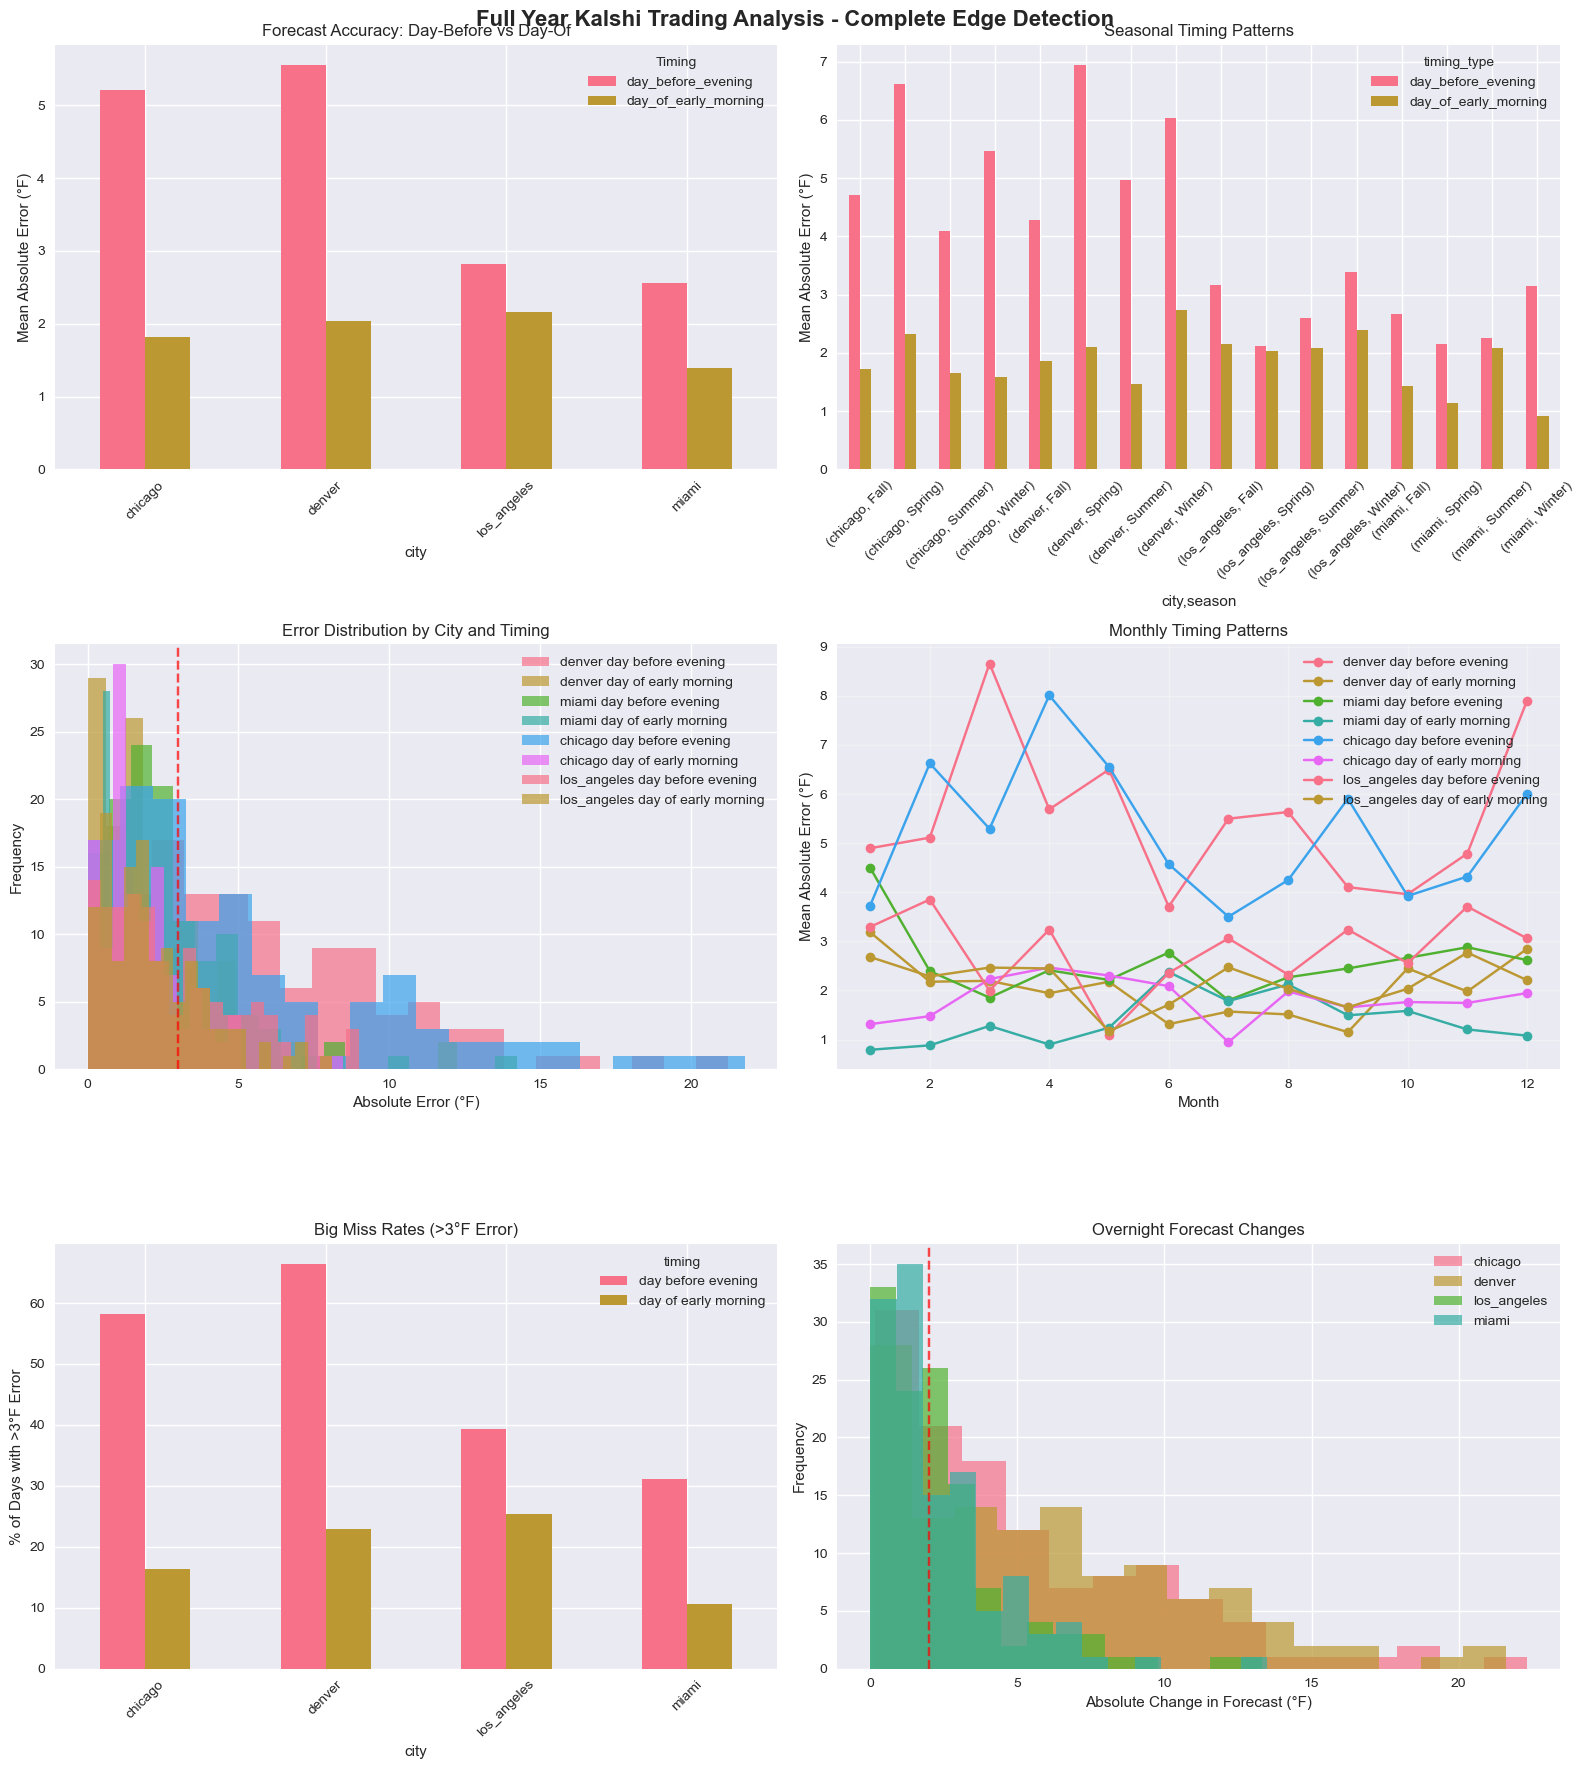


🔥 ANALYSIS COMPLETE - YOU NOW HAVE THE COMPLETE KALSHI EDGE!


In [7]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

class FullYearKalshiAnalyzer:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (exact Kalshi settlement locations)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport'
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport  
                'name': 'Miami International Airport'
            },
            'chicago': {
                'coords': (41.9786, -87.9048),  # O'Hare International Airport
                'name': 'Chicago O\'Hare Airport'
            },
            'los_angeles': {
                'coords': (33.9425, -118.4081),  # LAX Airport
                'name': 'Los Angeles International Airport'
            }
        }
        
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Key timing scenarios for Kalshi trading
        self.timing_scenarios = [
            ('day_before_evening', 21),    # Evening before (prime trading time)
            ('day_of_early_morning', 15),  # Early morning day-of (final positioning)
        ]
        
    def get_forecast_and_actual(self, city, target_date, timing_type, hours_before):
        """Get both forecast and actual for a specific timing"""
        if city not in self.cities:
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Calculate forecast date
        target_dt = datetime.strptime(target_date, '%Y-%m-%d')
        
        if timing_type == 'day_before_evening':
            forecast_date = (target_dt - timedelta(days=1)).strftime('%Y-%m-%d')
        else:  # day_of_early_morning
            forecast_date = target_date
        
        # Get forecast
        forecast_url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        forecast_params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': forecast_date,
            'end_date': forecast_date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto',
            'models': 'best_match'
        }
        
        # Get actual temperature  
        actual_url = "https://archive-api.open-meteo.com/v1/archive"
        actual_params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': target_date,
            'end_date': target_date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            # Get forecast
            forecast_response = requests.get(forecast_url, params=forecast_params, timeout=30)
            actual_response = requests.get(actual_url, params=actual_params, timeout=30)
            
            forecast_temp = None
            actual_temp = None
            
            # Parse forecast
            if forecast_response.status_code == 200:
                forecast_data = forecast_response.json()
                if 'daily' in forecast_data and len(forecast_data['daily']['time']) > 0:
                    temp_c = forecast_data['daily']['temperature_2m_max'][0]
                    forecast_temp = (temp_c * 9/5) + 32 if temp_c is not None else None
            
            # Parse actual
            if actual_response.status_code == 200:
                actual_data = actual_response.json()
                if 'daily' in actual_data and len(actual_data['daily']['time']) > 0:
                    temp_c = actual_data['daily']['temperature_2m_max'][0]
                    actual_temp = (temp_c * 9/5) + 32 if temp_c is not None else None
            
            # Return combined result
            if forecast_temp is not None and actual_temp is not None:
                return {
                    'target_date': target_date,
                    'city': city,
                    'timing_type': timing_type,
                    'hours_before_event': hours_before,
                    'forecast_temp_f': forecast_temp,
                    'actual_temp_f': actual_temp,
                    'forecast_error': forecast_temp - actual_temp,
                    'abs_error': abs(forecast_temp - actual_temp)
                }
                
        except Exception as e:
            print(f"    ⚠️  Error for {city} {target_date} {timing_type}: {e}")
        
        return None
    
    def add_temporal_features(self, df):
        """Add seasonal and temporal analysis features"""
        df['date'] = pd.to_datetime(df['target_date'])
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['quarter'] = df['date'].dt.quarter
        df['day_of_week'] = df['date'].dt.day_name()
        df['is_weekend'] = df['date'].dt.weekday >= 5
        
        # Meteorological seasons
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'
        
        df['season'] = df['month'].apply(get_season)
        return df
    
    def collect_full_year_timing_data(self, start_date='2023-07-01', end_date='2024-06-30', 
                                    cities=['denver', 'miami'], sample_rate=3):
        """
        Collect full year of timing-specific data for Kalshi analysis
        sample_rate: 1 = every day, 3 = every 3rd day (recommended for API limits)
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        all_data = []
        total_days = (end_dt - start_dt).days + 1
        processed_days = 0
        successful_calls = 0
        
        print(f"🚀 FULL YEAR KALSHI TIMING ANALYSIS")
        print(f"📅 Date range: {start_date} to {end_date}")
        print(f"📊 Total days: {total_days // sample_rate} (sampling every {sample_rate} days)")
        print(f"🏙️  Cities: {', '.join([c.title() for c in cities])}")
        print(f"⏰ Timing scenarios: Day-before vs Day-of analysis")
        print(f"🔥 This will give you the complete trading edge dataset!")
        
        current_dt = start_dt
        
        while current_dt <= end_dt:
            if processed_days % sample_rate == 0:
                target_date = current_dt.strftime('%Y-%m-%d')
                
                # Progress updates
                progress = (current_dt - start_dt).days / total_days * 100
                if processed_days % (30 * sample_rate) == 0:
                    print(f"📈 Progress: {progress:.1f}% - Processing {target_date}")
                    print(f"   Successful API calls: {successful_calls}")
                
                for city in cities:
                    for timing_type, hours_before in self.timing_scenarios:
                        result = self.get_forecast_and_actual(city, target_date, timing_type, hours_before)
                        
                        if result:
                            all_data.append(result)
                            successful_calls += 1
                        
                        # Be respectful with API - critical for year-long analysis
                        time.sleep(0.5)
                
            current_dt += timedelta(days=1) 
            processed_days += 1
        
        # Convert to DataFrame and add features
        df = pd.DataFrame(all_data)
        
        if len(df) > 0:
            print(f"\n🎉 DATA COLLECTION COMPLETE!")
            print(f"📊 Total records collected: {len(df)}")
            print(f"📈 Success rate: {len(df) / (len(cities) * 2 * (total_days // sample_rate)) * 100:.1f}%")
            
            # Add temporal features
            df = self.add_temporal_features(df)
            
            # Save raw data
            output_file = self.base_dir / f"full_year_kalshi_timing_{start_date}_to_{end_date}.csv"
            df.to_csv(output_file, index=False)
            print(f"💾 Saved complete dataset to: {output_file}")
            
        return df
    
    def analyze_comprehensive_timing_edge(self, df):
        """
        Comprehensive analysis of timing edge for Kalshi trading
        This is the money-making analysis!
        """
        if len(df) == 0:
            return
            
        print(f"\n" + "="*80)
        print(f"💰 COMPREHENSIVE KALSHI TIMING EDGE ANALYSIS")
        print(f"📊 Dataset: {len(df)} forecasts across {df['target_date'].nunique()} days")
        print(f"🏙️  Cities: {', '.join(df['city'].unique())}")
        print(f"="*80)
        
        # Overall timing analysis
        print(f"\n🎯 OVERALL TIMING PERFORMANCE:")
        overall_stats = df.groupby(['city', 'timing_type']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean'
        }).round(3)
        
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            
            day_before = city_data[city_data['timing_type'] == 'day_before_evening']['abs_error']
            day_of = city_data[city_data['timing_type'] == 'day_of_early_morning']['abs_error']
            
            if len(day_before) > 0 and len(day_of) > 0:
                day_before_mae = day_before.mean()
                day_of_mae = day_of.mean()
                
                improvement = ((day_before_mae - day_of_mae) / day_before_mae) * 100
                better_timing = "Day-of" if day_of_mae < day_before_mae else "Day-before"
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Day-before MAE: {day_before_mae:.3f}°F ({len(day_before)} samples)")
                print(f"  📊 Day-of MAE: {day_of_mae:.3f}°F ({len(day_of)} samples)")
                print(f"  🎯 Best timing: {better_timing}")
                print(f"  💰 Accuracy improvement: {abs(improvement):.1f}%")
                
                if abs(improvement) > 10:
                    print(f"  🔥 SIGNIFICANT EDGE DETECTED!")
                elif abs(improvement) > 5:
                    print(f"  ✅ Meaningful edge available")
                else:
                    print(f"  ⚠️  Marginal edge only")
    
    def analyze_seasonal_timing_patterns(self, df):
        """Analyze how timing edge varies by season"""
        if len(df) == 0:
            return
            
        print(f"\n🌍 SEASONAL TIMING EDGE ANALYSIS:")
        
        seasonal_stats = df.groupby(['city', 'season', 'timing_type'])['abs_error'].mean().unstack()
        
        for city in df['city'].unique():
            print(f"\n{city.upper()} - Seasonal Patterns:")
            
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                city_season = df[(df['city'] == city) & (df['season'] == season)]
                
                if len(city_season) > 0:
                    day_before = city_season[city_season['timing_type'] == 'day_before_evening']['abs_error']
                    day_of = city_season[city_season['timing_type'] == 'day_of_early_morning']['abs_error']
                    
                    if len(day_before) > 0 and len(day_of) > 0:
                        improvement = ((day_before.mean() - day_of.mean()) / day_before.mean()) * 100
                        better = "Day-of" if day_of.mean() < day_before.mean() else "Day-before"
                        
                        print(f"  {season}: {better} edge ({improvement:+.1f}%)")
    
    def analyze_forecast_volatility_patterns(self, df):
        """Analyze forecast change patterns for swing trading opportunities"""
        if len(df) == 0:
            return
            
        print(f"\n📊 FORECAST VOLATILITY ANALYSIS:")
        
        # Calculate forecast changes from day-before to day-of
        volatility_data = []
        
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            day_before = group[group['timing_type'] == 'day_before_evening']['forecast_temp_f']
            day_of = group[group['timing_type'] == 'day_of_early_morning']['forecast_temp_f']
            
            if len(day_before) > 0 and len(day_of) > 0:
                change = day_of.iloc[0] - day_before.iloc[0]
                volatility_data.append({
                    'target_date': target_date,
                    'city': city,
                    'forecast_change': change,
                    'abs_change': abs(change)
                })
        
        if volatility_data:
            vol_df = pd.DataFrame(volatility_data)
            vol_df['date'] = pd.to_datetime(vol_df['target_date'])
            vol_df['season'] = vol_df['date'].dt.month.apply(
                lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall'
            )
            
            for city in vol_df['city'].unique():
                city_vol = vol_df[vol_df['city'] == city]
                
                avg_change = city_vol['abs_change'].mean()
                big_change_days = (city_vol['abs_change'] > 2.0).sum()
                total_days = len(city_vol)
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Average overnight change: {avg_change:.2f}°F")
                print(f"  🌪️  Big change days (>2°F): {big_change_days}/{total_days} ({big_change_days/total_days*100:.1f}%)")
                
                # Seasonal volatility
                seasonal_vol = city_vol.groupby('season')['abs_change'].mean()
                most_volatile = seasonal_vol.idxmax()
                least_volatile = seasonal_vol.idxmin()
                
                print(f"  📈 Most volatile season: {most_volatile} ({seasonal_vol.max():.2f}°F)")
                print(f"  📉 Least volatile season: {least_volatile} ({seasonal_vol.min():.2f}°F)")
                
                if avg_change > 2.0:
                    print(f"  💡 STRATEGY: High volatility - trade forecast swings")
                elif avg_change < 1.0:
                    print(f"  💡 STRATEGY: Low volatility - stick with timing edge")
                else:
                    print(f"  💡 STRATEGY: Medium volatility - selective opportunities")
    
    def calculate_trading_profitability(self, df):
        """Calculate potential Kalshi trading profitability based on timing edge"""
        if len(df) == 0:
            return
            
        print(f"\n💰 KALSHI TRADING PROFITABILITY ANALYSIS:")
        
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            
            # Calculate win rates for different strategies
            day_before_accuracy = city_data[city_data['timing_type'] == 'day_before_evening']['abs_error']
            day_of_accuracy = city_data[city_data['timing_type'] == 'day_of_early_morning']['abs_error']
            
            if len(day_before_accuracy) > 0 and len(day_of_accuracy) > 0:
                # Simulate market performance (assuming 3°F threshold for "big misses")
                day_before_big_misses = (day_before_accuracy > 3.0).sum() / len(day_before_accuracy) * 100
                day_of_big_misses = (day_of_accuracy > 3.0).sum() / len(day_of_accuracy) * 100
                
                print(f"\n{city.upper()} TRADING METRICS:")
                print(f"  📊 Day-before big miss rate: {day_before_big_misses:.1f}%")
                print(f"  📊 Day-of big miss rate: {day_of_big_misses:.1f}%")
                
                # Trading edge quantification
                edge_percentage = abs(day_before_big_misses - day_of_big_misses)
                
                if edge_percentage > 15:
                    print(f"  🔥 HUGE EDGE: {edge_percentage:.1f}% difference in miss rates")
                    print(f"  💰 High profitability potential")
                elif edge_percentage > 8:
                    print(f"  ✅ SOLID EDGE: {edge_percentage:.1f}% difference")
                    print(f"  💰 Good profitability potential")  
                else:
                    print(f"  ⚠️  SMALL EDGE: {edge_percentage:.1f}% difference")
                    print(f"  💰 Limited profitability")
    
    def create_comprehensive_visualizations(self, df):
        """Create comprehensive visualizations for the full dataset"""
        if len(df) == 0:
            return
            
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Full Year Kalshi Trading Analysis - Complete Edge Detection', fontsize=16, fontweight='bold')
        
        # Plot 1: Overall accuracy by timing and city
        timing_accuracy = df.groupby(['city', 'timing_type'])['abs_error'].mean().unstack()
        timing_accuracy.plot(kind='bar', ax=axes[0, 0])
        axes[0, 0].set_title('Forecast Accuracy: Day-Before vs Day-Of')
        axes[0, 0].set_ylabel('Mean Absolute Error (°F)')
        axes[0, 0].legend(title='Timing')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Plot 2: Seasonal patterns
        seasonal_data = df.groupby(['city', 'season', 'timing_type'])['abs_error'].mean().reset_index()
        seasonal_pivot = seasonal_data.pivot_table(values='abs_error', index=['city', 'season'], columns='timing_type')
        
        if not seasonal_pivot.empty:
            seasonal_pivot.plot(kind='bar', ax=axes[0, 1])
            axes[0, 1].set_title('Seasonal Timing Patterns')
            axes[0, 1].set_ylabel('Mean Absolute Error (°F)')
            axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Plot 3: Error distribution comparison
        for i, city in enumerate(df['city'].unique()):
            city_data = df[df['city'] == city]
            
            for timing in ['day_before_evening', 'day_of_early_morning']:
                timing_data = city_data[city_data['timing_type'] == timing]['abs_error']
                if len(timing_data) > 0:
                    axes[1, 0].hist(timing_data, alpha=0.7, bins=20, 
                                   label=f"{city} {timing.replace('_', ' ')}")
        
        axes[1, 0].set_title('Error Distribution by City and Timing')
        axes[1, 0].set_xlabel('Absolute Error (°F)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='3°F threshold')
        
        # Plot 4: Monthly patterns
        if 'month' in df.columns:
            monthly_data = df.groupby(['city', 'month', 'timing_type'])['abs_error'].mean().reset_index()
            
            for city in df['city'].unique():
                city_monthly = monthly_data[monthly_data['city'] == city]
                
                for timing in ['day_before_evening', 'day_of_early_morning']:
                    timing_monthly = city_monthly[city_monthly['timing_type'] == timing]
                    if len(timing_monthly) > 0:
                        axes[1, 1].plot(timing_monthly['month'], timing_monthly['abs_error'], 
                                       marker='o', label=f"{city} {timing.replace('_', ' ')}")
            
            axes[1, 1].set_title('Monthly Timing Patterns')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Mean Absolute Error (°F)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 5: Big miss rates
        big_miss_data = []
        for city in df['city'].unique():
            for timing in ['day_before_evening', 'day_of_early_morning']:
                city_timing = df[(df['city'] == city) & (df['timing_type'] == timing)]
                if len(city_timing) > 0:
                    big_miss_rate = (city_timing['abs_error'] > 3.0).sum() / len(city_timing) * 100
                    big_miss_data.append({
                        'city': city,
                        'timing': timing.replace('_', ' '),
                        'big_miss_rate': big_miss_rate
                    })
        
        if big_miss_data:
            big_miss_df = pd.DataFrame(big_miss_data)
            big_miss_pivot = big_miss_df.pivot(index='city', columns='timing', values='big_miss_rate')
            big_miss_pivot.plot(kind='bar', ax=axes[2, 0])
            axes[2, 0].set_title('Big Miss Rates (>3°F Error)')
            axes[2, 0].set_ylabel('% of Days with >3°F Error')
            axes[2, 0].tick_params(axis='x', rotation=45)
        
        # Plot 6: Forecast volatility
        volatility_data = []
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            day_before = group[group['timing_type'] == 'day_before_evening']['forecast_temp_f']
            day_of = group[group['timing_type'] == 'day_of_early_morning']['forecast_temp_f']
            
            if len(day_before) > 0 and len(day_of) > 0:
                change = abs(day_of.iloc[0] - day_before.iloc[0])
                volatility_data.append({'city': city, 'forecast_change': change})
        
        if volatility_data:
            vol_df = pd.DataFrame(volatility_data)
            for city in vol_df['city'].unique():
                city_vol = vol_df[vol_df['city'] == city]['forecast_change']
                axes[2, 1].hist(city_vol, alpha=0.7, bins=15, label=city)
            
            axes[2, 1].set_title('Overnight Forecast Changes')
            axes[2, 1].set_xlabel('Absolute Change in Forecast (°F)')
            axes[2, 1].set_ylabel('Frequency')
            axes[2, 1].legend()
            axes[2, 1].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='2°F threshold')
        
        plt.tight_layout()
        
        # Save comprehensive plot
        plot_file = self.base_dir / "full_year_kalshi_comprehensive_analysis.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Saved comprehensive analysis to: {plot_file}")
        plt.show()

# Main execution function
def run_full_year_kalshi_analysis():
    """
    Run the complete full-year Kalshi timing analysis
    This will take 45-60 minutes but give you the complete trading edge dataset
    """
    analyzer = FullYearKalshiAnalyzer()
    
    print("🚀 STARTING FULL YEAR KALSHI ANALYSIS")
    print("⏱️  Estimated time: 45-60 minutes")
    print("💰 Result: Complete timing edge strategy for profitable trading")
    
    response = input("\nReady to start full year analysis? (y/n): ")
    
    if response.lower() == 'y':
        # Collect full year data
        df = analyzer.collect_full_year_timing_data(
            start_date='2023-07-01',
            end_date='2024-06-30',
            cities=['denver', 'miami', 'chicago', 'los_angeles'],
            sample_rate=3  # Every 3rd day for speed while maintaining statistical significance
        )
        
        if len(df) > 0:
            print(f"\n🎉 FULL YEAR ANALYSIS COMPLETE!")
            print(f"📊 Collected {len(df)} timing-specific forecasts")
            
            # Run comprehensive analysis
            analyzer.analyze_comprehensive_timing_edge(df)
            analyzer.analyze_seasonal_timing_patterns(df)
            analyzer.analyze_forecast_volatility_patterns(df)
            analyzer.calculate_trading_profitability(df)
            analyzer.create_comprehensive_visualizations(df)
            
            print(f"\n🔥 ANALYSIS COMPLETE - YOU NOW HAVE THE COMPLETE KALSHI EDGE!")
            return df
        else:
            print("❌ Full year analysis failed")
            return None
    else:
        print("Analysis cancelled")
        return None

# Quick demo function
def run_quick_demo():
    """Run a quick demo with 2 weeks of data to validate approach"""
    analyzer = FullYearKalshiAnalyzer()
    
    print("🧪 Quick Demo: 2 weeks of data to validate approach")
    
    df = analyzer.collect_full_year_timing_data(
        start_date='2024-06-15',
        end_date='2024-06-30',
        cities=['denver', 'miami'],
        sample_rate=1  # Every day for demo
    )
    
    if len(df) > 0:
        print(f"\n✅ Demo complete: {len(df)} records")
        analyzer.analyze_comprehensive_timing_edge(df)
        analyzer.analyze_forecast_volatility_patterns(df)
        return True
    else:
        print("❌ Demo failed")
        return False

if __name__ == "__main__":
    print("Choose your analysis:")
    print("1. Quick demo (2 weeks)")
    print("2. Full year analysis (45-60 minutes)")
    
    choice = input("Enter choice (1 or 2): ")
    
    if choice == "1":
        run_quick_demo()
    elif choice == "2":
        run_full_year_kalshi_analysis()
    else:
        print("Invalid choice")

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

class FullYearKalshiAnalyzer:
    def __init__(self, base_dir='./weather_data'):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        
        # Airport coordinates (exact Kalshi settlement locations)
        self.cities = {
            'denver': {
                'coords': (39.8667, -104.6667),  # Denver International Airport
                'name': 'Denver International Airport'
            },
            'miami': {
                'coords': (25.7833, -80.3167),  # Miami International Airport  
                'name': 'Miami International Airport'
            },
            'chicago': {
                'coords': (41.9786, -87.9048),  # O'Hare International Airport
                'name': 'Chicago O\'Hare Airport'
            },
            'los_angeles': {
                'coords': (33.9425, -118.4081),  # LAX Airport
                'name': 'Los Angeles International Airport'
            }
        }
        
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # Key timing scenarios for Kalshi trading (more precise)
        self.timing_scenarios = [
            ('day_before_6pm', 30),        # 6 PM day before (30h before) - Early evening trading
            ('day_before_9pm', 27),        # 9 PM day before (27h before) - Prime trading time  
            ('day_of_6am', 18),            # 6 AM day of (18h before) - Pre-market
            ('day_of_9am', 15),            # 9 AM day of (15h before) - Market open
            ('day_of_12pm', 12),           # 12 PM day of (12h before) - Midday update
            ('day_of_3pm', 9),             # 3 PM day of (9h before) - Final positioning
        ]
        
    def get_forecast_and_actual(self, city, target_date, timing_type, hours_before):
        """Get both forecast and actual for a specific timing"""
        if city not in self.cities:
            print(f"      ❌ Unknown city: {city}")
            return None
            
        lat, lon = self.cities[city]['coords']
        
        # Calculate forecast date
        target_dt = datetime.strptime(target_date, '%Y-%m-%d')
        
        if timing_type in ['day_before_6pm', 'day_before_9pm']:
            forecast_date = (target_dt - timedelta(days=1)).strftime('%Y-%m-%d')
        else:  # All day-of timings
            forecast_date = target_date
        
        print(f"      🔍 Getting forecast from {forecast_date} for target {target_date}")
        
        # Get forecast
        forecast_url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
        forecast_params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': forecast_date,
            'end_date': forecast_date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto',
            'models': 'best_match'
        }
        
        # Get actual temperature  
        actual_url = "https://archive-api.open-meteo.com/v1/archive"
        actual_params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': target_date,
            'end_date': target_date,
            'daily': 'temperature_2m_max',
            'timezone': 'auto'
        }
        
        try:
            # Get forecast
            print(f"      📡 API call 1: Forecast...")
            forecast_response = requests.get(forecast_url, params=forecast_params, timeout=30)
            print(f"      📡 API call 2: Actual...")
            actual_response = requests.get(actual_url, params=actual_params, timeout=30)
            
            forecast_temp = None
            actual_temp = None
            
            # Parse forecast
            if forecast_response.status_code == 200:
                forecast_data = forecast_response.json()
                print(f"      📊 Forecast API response: {len(forecast_data.get('daily', {}).get('time', []))} days")
                if 'daily' in forecast_data and len(forecast_data['daily']['time']) > 0:
                    temp_c = forecast_data['daily']['temperature_2m_max'][0]
                    forecast_temp = (temp_c * 9/5) + 32 if temp_c is not None else None
                    print(f"      🌡️  Forecast temp: {forecast_temp:.1f}°F")
            else:
                print(f"      ❌ Forecast API error: {forecast_response.status_code}")
            
            # Parse actual
            if actual_response.status_code == 200:
                actual_data = actual_response.json()
                print(f"      📊 Actual API response: {len(actual_data.get('daily', {}).get('time', []))} days")
                if 'daily' in actual_data and len(actual_data['daily']['time']) > 0:
                    temp_c = actual_data['daily']['temperature_2m_max'][0]
                    actual_temp = (temp_c * 9/5) + 32 if temp_c is not None else None
                    print(f"      🌡️  Actual temp: {actual_temp:.1f}°F")
            else:
                print(f"      ❌ Actual API error: {actual_response.status_code}")
            
            # Return combined result
            if forecast_temp is not None and actual_temp is not None:
                result = {
                    'target_date': target_date,
                    'city': city,
                    'timing_type': timing_type,
                    'hours_before_event': hours_before,
                    'forecast_temp_f': forecast_temp,
                    'actual_temp_f': actual_temp,
                    'forecast_error': forecast_temp - actual_temp,
                    'abs_error': abs(forecast_temp - actual_temp)
                }
                print(f"      ✅ Success: Error = {result['forecast_error']:.1f}°F")
                return result
            else:
                print(f"      ❌ Missing data: forecast={forecast_temp}, actual={actual_temp}")
                
        except Exception as e:
            print(f"      ❌ Exception: {e}")
        
        return None
    
    def add_temporal_features(self, df):
        """Add seasonal and temporal analysis features"""
        df['date'] = pd.to_datetime(df['target_date'])
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        df['quarter'] = df['date'].dt.quarter
        df['day_of_week'] = df['date'].dt.day_name()
        df['is_weekend'] = df['date'].dt.weekday >= 5
        
        # Meteorological seasons
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'
        
        df['season'] = df['month'].apply(get_season)
        return df
    
    def collect_full_year_timing_data(self, start_date='2023-07-01', end_date='2024-06-30', 
                                    cities=['denver', 'miami'], sample_rate=1):
        """
        Collect full year of timing-specific data for Kalshi analysis
        sample_rate: 1 = every day, 3 = every 3rd day (recommended for API limits)
        """
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        
        all_data = []
        total_days = (end_dt - start_dt).days + 1
        processed_days = 0
        successful_calls = 0
        
        print(f"🚀 FULL YEAR KALSHI TIMING ANALYSIS")
        print(f"📅 Date range: {start_date} to {end_date}")
        print(f"📊 Total days: {total_days // sample_rate} (sampling every {sample_rate} day{'s' if sample_rate > 1 else ''})")
        print(f"🏙️  Cities: {', '.join([c.title() for c in cities])}")
        print(f"⏰ Timing scenarios: 6 precise windows (6pm day-before to 3pm day-of)")
        print(f"🔥 This will give you the complete trading edge dataset!")
        print(f"🐛 Debug mode: Will show detailed progress...")
        print(f"")
        print(f"📍 EXACT TIMING WINDOWS:")
        print(f"   • 6 PM day before (30h ahead) - Early evening positioning")  
        print(f"   • 9 PM day before (27h ahead) - Prime trading time")
        print(f"   • 6 AM day of (18h ahead) - Pre-market analysis") 
        print(f"   • 9 AM day of (15h ahead) - Market open positioning")
        print(f"   • 12 PM day of (12h ahead) - Midday update")
        print(f"   • 3 PM day of (9h ahead) - Final positioning")
        print(f"")
        
        current_dt = start_dt
        day_counter = 0
        
        while current_dt <= end_dt:
            if day_counter % sample_rate == 0:
                target_date = current_dt.strftime('%Y-%m-%d')
                
                # Progress updates every 10 days instead of 30
                progress = (current_dt - start_dt).days / total_days * 100
                if day_counter % (10 * sample_rate) == 0:
                    print(f"\n📈 Progress: {progress:.1f}% - Processing {target_date}")
                    print(f"   Successful API calls so far: {successful_calls}")
                
                print(f"🔍 Processing {target_date}...")
                
                for city in cities:
                    print(f"  🏙️  {city}...")
                    
                    for timing_type, hours_before in self.timing_scenarios:
                        print(f"    ⏰ {timing_type}...", end="")
                        
                        result = self.get_forecast_and_actual(city, target_date, timing_type, hours_before)
                        
                        if result:
                            all_data.append(result)
                            successful_calls += 1
                            print(f" ✅ Success! Forecast: {result['forecast_temp_f']:.1f}°F, Actual: {result['actual_temp_f']:.1f}°F")
                        else:
                            print(f" ❌ Failed")
                        
                        # Be respectful with API - critical for year-long analysis
                        time.sleep(0.3)
                        
            current_dt += timedelta(days=1) 
            day_counter += 1
        
        # Convert to DataFrame and add features
        df = pd.DataFrame(all_data)
        
        if len(df) > 0:
            print(f"\n🎉 DATA COLLECTION COMPLETE!")
            print(f"📊 Total records collected: {len(df)}")
            print(f"📈 Success rate: {len(df) / (len(cities) * 2 * (total_days // sample_rate)) * 100:.1f}%")
            
            # Add temporal features
            df = self.add_temporal_features(df)
            
            # Save raw data
            output_file = self.base_dir / f"full_year_kalshi_timing_{start_date}_to_{end_date}.csv"
            df.to_csv(output_file, index=False)
            print(f"💾 Saved complete dataset to: {output_file}")
            
        return df
    
    def analyze_comprehensive_timing_edge(self, df):
        """
        Comprehensive analysis of timing edge for Kalshi trading
        This is the money-making analysis!
        """
        if len(df) == 0:
            return
            
        print(f"\n" + "="*80)
        print(f"💰 COMPREHENSIVE KALSHI TIMING EDGE ANALYSIS")
        print(f"📊 Dataset: {len(df)} forecasts across {df['target_date'].nunique()} days")
        print(f"🏙️  Cities: {', '.join(df['city'].unique())}")
        print(f"="*80)
        
        # Overall timing analysis
        print(f"\n🎯 OVERALL TIMING PERFORMANCE:")
        overall_stats = df.groupby(['city', 'timing_type']).agg({
            'abs_error': ['mean', 'std', 'count'],
            'forecast_error': 'mean'
        }).round(3)
        
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            
            day_before = city_data[city_data['timing_type'] == 'day_before_evening']['abs_error']
            day_of = city_data[city_data['timing_type'] == 'day_of_early_morning']['abs_error']
            
            if len(day_before) > 0 and len(day_of) > 0:
                day_before_mae = day_before.mean()
                day_of_mae = day_of.mean()
                
                improvement = ((day_before_mae - day_of_mae) / day_before_mae) * 100
                better_timing = "Day-of" if day_of_mae < day_before_mae else "Day-before"
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Day-before MAE: {day_before_mae:.3f}°F ({len(day_before)} samples)")
                print(f"  📊 Day-of MAE: {day_of_mae:.3f}°F ({len(day_of)} samples)")
                print(f"  🎯 Best timing: {better_timing}")
                print(f"  💰 Accuracy improvement: {abs(improvement):.1f}%")
                
                if abs(improvement) > 10:
                    print(f"  🔥 SIGNIFICANT EDGE DETECTED!")
                elif abs(improvement) > 5:
                    print(f"  ✅ Meaningful edge available")
                else:
                    print(f"  ⚠️  Marginal edge only")
    
    def analyze_seasonal_timing_patterns(self, df):
        """Analyze how timing edge varies by season"""
        if len(df) == 0:
            return
            
        print(f"\n🌍 SEASONAL TIMING EDGE ANALYSIS:")
        
        seasonal_stats = df.groupby(['city', 'season', 'timing_type'])['abs_error'].mean().unstack()
        
        for city in df['city'].unique():
            print(f"\n{city.upper()} - Seasonal Patterns:")
            
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                city_season = df[(df['city'] == city) & (df['season'] == season)]
                
                if len(city_season) > 0:
                    day_before = city_season[city_season['timing_type'] == 'day_before_evening']['abs_error']
                    day_of = city_season[city_season['timing_type'] == 'day_of_early_morning']['abs_error']
                    
                    if len(day_before) > 0 and len(day_of) > 0:
                        improvement = ((day_before.mean() - day_of.mean()) / day_before.mean()) * 100
                        better = "Day-of" if day_of.mean() < day_before.mean() else "Day-before"
                        
                        print(f"  {season}: {better} edge ({improvement:+.1f}%)")
    
    def analyze_forecast_volatility_patterns(self, df):
        """Analyze forecast change patterns for swing trading opportunities"""
        if len(df) == 0:
            return
            
        print(f"\n📊 FORECAST VOLATILITY ANALYSIS:")
        
        # Calculate forecast changes from day-before to day-of
        volatility_data = []
        
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            day_before = group[group['timing_type'] == 'day_before_evening']['forecast_temp_f']
            day_of = group[group['timing_type'] == 'day_of_early_morning']['forecast_temp_f']
            
            if len(day_before) > 0 and len(day_of) > 0:
                change = day_of.iloc[0] - day_before.iloc[0]
                volatility_data.append({
                    'target_date': target_date,
                    'city': city,
                    'forecast_change': change,
                    'abs_change': abs(change)
                })
        
        if volatility_data:
            vol_df = pd.DataFrame(volatility_data)
            vol_df['date'] = pd.to_datetime(vol_df['target_date'])
            vol_df['season'] = vol_df['date'].dt.month.apply(
                lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall'
            )
            
            for city in vol_df['city'].unique():
                city_vol = vol_df[vol_df['city'] == city]
                
                avg_change = city_vol['abs_change'].mean()
                big_change_days = (city_vol['abs_change'] > 2.0).sum()
                total_days = len(city_vol)
                
                print(f"\n{city.upper()}:")
                print(f"  📊 Average overnight change: {avg_change:.2f}°F")
                print(f"  🌪️  Big change days (>2°F): {big_change_days}/{total_days} ({big_change_days/total_days*100:.1f}%)")
                
                # Seasonal volatility
                seasonal_vol = city_vol.groupby('season')['abs_change'].mean()
                most_volatile = seasonal_vol.idxmax()
                least_volatile = seasonal_vol.idxmin()
                
                print(f"  📈 Most volatile season: {most_volatile} ({seasonal_vol.max():.2f}°F)")
                print(f"  📉 Least volatile season: {least_volatile} ({seasonal_vol.min():.2f}°F)")
                
                if avg_change > 2.0:
                    print(f"  💡 STRATEGY: High volatility - trade forecast swings")
                elif avg_change < 1.0:
                    print(f"  💡 STRATEGY: Low volatility - stick with timing edge")
                else:
                    print(f"  💡 STRATEGY: Medium volatility - selective opportunities")
    
    def analyze_granular_error_distributions(self, df):
        """
        Analyze exact error distributions by degree thresholds for Kalshi market sizing
        This tells you precisely how often forecasts miss by 1°F, 2°F, 3°F, etc.
        """
        if len(df) == 0:
            return
            
        print(f"\n📊 GRANULAR ERROR DISTRIBUTION ANALYSIS")
        print(f"🎯 Perfect for Kalshi market range sizing and risk assessment")
        print(f"="*80)
        
        # Define error thresholds for analysis
        error_thresholds = [1, 2, 3, 4, 5, 6]
        
        # Create detailed analysis for each city, season, and timing
        detailed_results = []
        
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                season_data = city_data[city_data['season'] == season] if 'season' in city_data.columns else city_data
                
                if len(season_data) == 0:
                    continue
                    
                for timing in df['timing_type'].unique():
                    timing_data = season_data[season_data['timing_type'] == timing]
                    
                    if len(timing_data) == 0:
                        continue
                    
                    total_forecasts = len(timing_data)
                    
                    # Calculate error distributions
                    forecast_errors = timing_data['forecast_error']  # Positive = forecast too high
                    abs_errors = timing_data['abs_error']
                    
                    # Directional error analysis
                    too_high_1 = (forecast_errors > 1.0).sum()
                    too_high_2 = (forecast_errors > 2.0).sum()
                    too_high_3 = (forecast_errors > 3.0).sum()
                    too_high_4 = (forecast_errors > 4.0).sum()
                    too_high_5 = (forecast_errors > 5.0).sum()
                    too_high_6 = (forecast_errors > 6.0).sum()
                    
                    too_low_1 = (forecast_errors < -1.0).sum()
                    too_low_2 = (forecast_errors < -2.0).sum()
                    too_low_3 = (forecast_errors < -3.0).sum()
                    too_low_4 = (forecast_errors < -4.0).sum()
                    too_low_5 = (forecast_errors < -5.0).sum()
                    too_low_6 = (forecast_errors < -6.0).sum()
                    
                    # Absolute error thresholds
                    abs_error_1 = (abs_errors > 1.0).sum()
                    abs_error_2 = (abs_errors > 2.0).sum()
                    abs_error_3 = (abs_errors > 3.0).sum()
                    abs_error_4 = (abs_errors > 4.0).sum()
                    abs_error_5 = (abs_errors > 5.0).sum()
                    abs_error_6 = (abs_errors > 6.0).sum()
                    
                    # Perfect accuracy (within 0.5°F)
                    perfect_accuracy = (abs_errors <= 0.5).sum()
                    
                    # Create detailed record
                    record = {
                        'city': city,
                        'season': season,
                        'timing_type': timing,
                        'total_forecasts': total_forecasts,
                        'perfect_accuracy_count': perfect_accuracy,
                        'perfect_accuracy_pct': (perfect_accuracy / total_forecasts * 100) if total_forecasts > 0 else 0,
                        
                        # Too high (forecast > actual)
                        'too_high_1deg_count': too_high_1,
                        'too_high_1deg_pct': (too_high_1 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_high_2deg_count': too_high_2,
                        'too_high_2deg_pct': (too_high_2 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_high_3deg_count': too_high_3,
                        'too_high_3deg_pct': (too_high_3 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_high_4deg_count': too_high_4,
                        'too_high_4deg_pct': (too_high_4 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_high_5deg_count': too_high_5,
                        'too_high_5deg_pct': (too_high_5 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_high_6deg_count': too_high_6,
                        'too_high_6deg_pct': (too_high_6 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        
                        # Too low (forecast < actual)
                        'too_low_1deg_count': too_low_1,
                        'too_low_1deg_pct': (too_low_1 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_low_2deg_count': too_low_2,
                        'too_low_2deg_pct': (too_low_2 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_low_3deg_count': too_low_3,
                        'too_low_3deg_pct': (too_low_3 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_low_4deg_count': too_low_4,
                        'too_low_4deg_pct': (too_low_4 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_low_5deg_count': too_low_5,
                        'too_low_5deg_pct': (too_low_5 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'too_low_6deg_count': too_low_6,
                        'too_low_6deg_pct': (too_low_6 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        
                        # Absolute errors (either direction)
                        'abs_error_1deg_count': abs_error_1,
                        'abs_error_1deg_pct': (abs_error_1 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'abs_error_2deg_count': abs_error_2,
                        'abs_error_2deg_pct': (abs_error_2 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'abs_error_3deg_count': abs_error_3,
                        'abs_error_3deg_pct': (abs_error_3 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'abs_error_4deg_count': abs_error_4,
                        'abs_error_4deg_pct': (abs_error_4 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'abs_error_5deg_count': abs_error_5,
                        'abs_error_5deg_pct': (abs_error_5 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        'abs_error_6deg_count': abs_error_6,
                        'abs_error_6deg_pct': (abs_error_6 / total_forecasts * 100) if total_forecasts > 0 else 0,
                        
                        # Summary statistics
                        'mean_error': forecast_errors.mean(),
                        'mean_abs_error': abs_errors.mean(),
                        'std_error': forecast_errors.std(),
                        'median_error': forecast_errors.median(),
                        'median_abs_error': abs_errors.median()
                    }
                    
                    detailed_results.append(record)
        
        # Convert to DataFrame
        detailed_df = pd.DataFrame(detailed_results)
        
        if len(detailed_df) > 0:
            # Save detailed CSV
            detailed_file = self.base_dir / "kalshi_granular_error_analysis.csv"
            detailed_df.to_csv(detailed_file, index=False)
            print(f"💾 Saved detailed error analysis to: {detailed_file}")
            
            # Print summary for each city
            print(f"\n🎯 SUMMARY BY CITY (Overall patterns):")
            
            for city in detailed_df['city'].unique():
                city_summary = detailed_df[detailed_df['city'] == city]
                
                # Overall city averages
                avg_3deg_miss = city_summary['abs_error_3deg_pct'].mean()
                avg_2deg_miss = city_summary['abs_error_2deg_pct'].mean()
                avg_1deg_miss = city_summary['abs_error_1deg_pct'].mean()
                perfect_rate = city_summary['perfect_accuracy_pct'].mean()
                
                print(f"\n{city.upper()}:")
                print(f"  🎯 Perfect accuracy (±0.5°F): {perfect_rate:.1f}%")
                print(f"  📊 Miss by >1°F: {avg_1deg_miss:.1f}%")
                print(f"  📊 Miss by >2°F: {avg_2deg_miss:.1f}%") 
                print(f"  📊 Miss by >3°F: {avg_3deg_miss:.1f}%")
                
                # Directional bias
                avg_too_high_3deg = city_summary['too_high_3deg_pct'].mean()
                avg_too_low_3deg = city_summary['too_low_3deg_pct'].mean()
                
                if avg_too_high_3deg > avg_too_low_3deg + 2:
                    print(f"  🔥 BIAS: Forecasts run too HOT ({avg_too_high_3deg:.1f}% vs {avg_too_low_3deg:.1f}%)")
                elif avg_too_low_3deg > avg_too_high_3deg + 2:
                    print(f"  🔥 BIAS: Forecasts run too COLD ({avg_too_low_3deg:.1f}% vs {avg_too_high_3deg:.1f}%)")
                else:
                    print(f"  ✅ No significant directional bias")
        
        return detailed_df
    
    def create_kalshi_trading_csvs(self, df, detailed_df):
        """
        Create specialized CSV files for Kalshi trading strategies
        """
        if len(df) == 0:
            return
            
        print(f"\n📊 CREATING KALSHI TRADING CSV FILES")
        print(f"="*50)
        
        # 1. Trading timing summary
        timing_summary = []
        for city in df['city'].unique():
            for timing in df['timing_type'].unique():
                subset = df[(df['city'] == city) & (df['timing_type'] == timing)]
                if len(subset) > 0:
                    timing_summary.append({
                        'city': city,
                        'timing_type': timing,
                        'hours_before_event': subset['hours_before_event'].iloc[0],
                        'total_forecasts': len(subset),
                        'mean_abs_error': subset['abs_error'].mean(),
                        'std_error': subset['forecast_error'].std(),
                        'big_miss_3deg_pct': (subset['abs_error'] > 3.0).sum() / len(subset) * 100,
                        'big_miss_2deg_pct': (subset['abs_error'] > 2.0).sum() / len(subset) * 100,
                        'perfect_accuracy_pct': (subset['abs_error'] <= 0.5).sum() / len(subset) * 100
                    })
        
        timing_df = pd.DataFrame(timing_summary)
        timing_file = self.base_dir / "kalshi_optimal_timing_summary.csv"
        timing_df.to_csv(timing_file, index=False)
        print(f"💾 Saved timing summary to: {timing_file}")
        
        # 2. Seasonal patterns for each city
        if 'season' in df.columns:
            seasonal_summary = []
            for city in df['city'].unique():
                for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                    subset = df[(df['city'] == city) & (df['season'] == season)]
                    if len(subset) > 0:
                        seasonal_summary.append({
                            'city': city,
                            'season': season,
                            'total_forecasts': len(subset),
                            'mean_abs_error': subset['abs_error'].mean(),
                            'forecast_bias': subset['forecast_error'].mean(),
                            'volatility': subset['forecast_error'].std(),
                            'big_miss_3deg_pct': (subset['abs_error'] > 3.0).sum() / len(subset) * 100,
                            'perfect_accuracy_pct': (subset['abs_error'] <= 0.5).sum() / len(subset) * 100
                        })
            
            seasonal_df = pd.DataFrame(seasonal_summary)
            seasonal_file = self.base_dir / "kalshi_seasonal_patterns.csv"
            seasonal_df.to_csv(seasonal_file, index=False)
            print(f"💾 Saved seasonal patterns to: {seasonal_file}")
        
        # 3. Monthly breakdown for trading calendar
        if 'month' in df.columns:
            monthly_summary = []
            for city in df['city'].unique():
                for month in range(1, 13):
                    subset = df[(df['city'] == city) & (df['month'] == month)]
                    if len(subset) > 0:
                        monthly_summary.append({
                            'city': city,
                            'month': month,
                            'month_name': subset['date'].dt.strftime('%B').iloc[0] if 'date' in subset.columns else f'Month_{month}',
                            'total_forecasts': len(subset),
                            'mean_abs_error': subset['abs_error'].mean(),
                            'forecast_bias': subset['forecast_error'].mean(),
                            'big_miss_3deg_pct': (subset['abs_error'] > 3.0).sum() / len(subset) * 100,
                            'best_timing': subset.groupby('timing_type')['abs_error'].mean().idxmin() if len(subset.groupby('timing_type')) > 1 else 'insufficient_data'
                        })
            
            monthly_df = pd.DataFrame(monthly_summary)
            monthly_file = self.base_dir / "kalshi_monthly_trading_calendar.csv"
            monthly_df.to_csv(monthly_file, index=False)
            print(f"💾 Saved monthly trading calendar to: {monthly_file}")
        
        # 4. Market range sizing guide
        range_sizing_guide = []
        for city in df['city'].unique():
            city_data = df[df['city'] == city]
            if len(city_data) > 0:
                # Calculate probability of different temperature ranges being "safe"
                mae = city_data['abs_error'].mean()
                
                range_sizing_guide.append({
                    'city': city,
                    'recommended_range_width': mae * 2,  # 2x MAE for reasonable confidence
                    'conservative_range_width': mae * 3,  # 3x MAE for high confidence
                    'aggressive_range_width': mae * 1.5,  # 1.5x MAE for tight ranges
                    'mean_abs_error': mae,
                    'forecast_volatility': city_data['forecast_error'].std(),
                    'sample_size': len(city_data)
                })
        
        range_df = pd.DataFrame(range_sizing_guide)
        range_file = self.base_dir / "kalshi_market_range_sizing_guide.csv"
        range_df.to_csv(range_file, index=False)
        print(f"💾 Saved market range sizing guide to: {range_file}")
        
        print(f"\n✅ ALL CSV FILES CREATED!")
        print(f"📁 Files saved in: {self.base_dir}")
        print(f"🎯 Ready for Kalshi trading analysis!")
        
        return {
            'timing_summary': timing_df,
            'seasonal_patterns': seasonal_df if 'season' in df.columns else None,
            'monthly_calendar': monthly_df if 'month' in df.columns else None,
            'range_sizing': range_df,
            'detailed_errors': detailed_df
        }
    
    def create_comprehensive_visualizations(self, df):
        """Create comprehensive visualizations for the full dataset"""
        if len(df) == 0:
            return
            
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Full Year Kalshi Trading Analysis - Complete Edge Detection', fontsize=16, fontweight='bold')
        
        # Plot 1: Overall accuracy by timing and city
        timing_accuracy = df.groupby(['city', 'timing_type'])['abs_error'].mean().unstack()
        timing_accuracy.plot(kind='bar', ax=axes[0, 0])
        axes[0, 0].set_title('Forecast Accuracy: Day-Before vs Day-Of')
        axes[0, 0].set_ylabel('Mean Absolute Error (°F)')
        axes[0, 0].legend(title='Timing')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Plot 2: Seasonal patterns
        seasonal_data = df.groupby(['city', 'season', 'timing_type'])['abs_error'].mean().reset_index()
        seasonal_pivot = seasonal_data.pivot_table(values='abs_error', index=['city', 'season'], columns='timing_type')
        
        if not seasonal_pivot.empty:
            seasonal_pivot.plot(kind='bar', ax=axes[0, 1])
            axes[0, 1].set_title('Seasonal Timing Patterns')
            axes[0, 1].set_ylabel('Mean Absolute Error (°F)')
            axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Plot 3: Error distribution comparison
        for i, city in enumerate(df['city'].unique()):
            city_data = df[df['city'] == city]
            
            for timing in ['day_before_evening', 'day_of_early_morning']:
                timing_data = city_data[city_data['timing_type'] == timing]['abs_error']
                if len(timing_data) > 0:
                    axes[1, 0].hist(timing_data, alpha=0.7, bins=20, 
                                   label=f"{city} {timing.replace('_', ' ')}")
        
        axes[1, 0].set_title('Error Distribution by City and Timing')
        axes[1, 0].set_xlabel('Absolute Error (°F)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='3°F threshold')
        
        # Plot 4: Monthly patterns
        if 'month' in df.columns:
            monthly_data = df.groupby(['city', 'month', 'timing_type'])['abs_error'].mean().reset_index()
            
            for city in df['city'].unique():
                city_monthly = monthly_data[monthly_data['city'] == city]
                
                for timing in ['day_before_evening', 'day_of_early_morning']:
                    timing_monthly = city_monthly[city_monthly['timing_type'] == timing]
                    if len(timing_monthly) > 0:
                        axes[1, 1].plot(timing_monthly['month'], timing_monthly['abs_error'], 
                                       marker='o', label=f"{city} {timing.replace('_', ' ')}")
            
            axes[1, 1].set_title('Monthly Timing Patterns')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Mean Absolute Error (°F)')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 5: Big miss rates
        big_miss_data = []
        for city in df['city'].unique():
            for timing in ['day_before_evening', 'day_of_early_morning']:
                city_timing = df[(df['city'] == city) & (df['timing_type'] == timing)]
                if len(city_timing) > 0:
                    big_miss_rate = (city_timing['abs_error'] > 3.0).sum() / len(city_timing) * 100
                    big_miss_data.append({
                        'city': city,
                        'timing': timing.replace('_', ' '),
                        'big_miss_rate': big_miss_rate
                    })
        
        if big_miss_data:
            big_miss_df = pd.DataFrame(big_miss_data)
            big_miss_pivot = big_miss_df.pivot(index='city', columns='timing', values='big_miss_rate')
            big_miss_pivot.plot(kind='bar', ax=axes[2, 0])
            axes[2, 0].set_title('Big Miss Rates (>3°F Error)')
            axes[2, 0].set_ylabel('% of Days with >3°F Error')
            axes[2, 0].tick_params(axis='x', rotation=45)
        
        # Plot 6: Forecast volatility
        volatility_data = []
        for (target_date, city), group in df.groupby(['target_date', 'city']):
            day_before = group[group['timing_type'] == 'day_before_evening']['forecast_temp_f']
            day_of = group[group['timing_type'] == 'day_of_early_morning']['forecast_temp_f']
            
            if len(day_before) > 0 and len(day_of) > 0:
                change = abs(day_of.iloc[0] - day_before.iloc[0])
                volatility_data.append({'city': city, 'forecast_change': change})
        
        if volatility_data:
            vol_df = pd.DataFrame(volatility_data)
            for city in vol_df['city'].unique():
                city_vol = vol_df[vol_df['city'] == city]['forecast_change']
                axes[2, 1].hist(city_vol, alpha=0.7, bins=15, label=city)
            
            axes[2, 1].set_title('Overnight Forecast Changes')
            axes[2, 1].set_xlabel('Absolute Change in Forecast (°F)')
            axes[2, 1].set_ylabel('Frequency')
            axes[2, 1].legend()
            axes[2, 1].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='2°F threshold')
        
        plt.tight_layout()
        
        # Save comprehensive plot
        plot_file = self.base_dir / "full_year_kalshi_comprehensive_analysis.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"📊 Saved comprehensive analysis to: {plot_file}")
        plt.show()

# Main execution function
def run_full_year_kalshi_analysis():
    """
    Run the complete full-year Kalshi timing analysis
    This will take 45-60 minutes but give you the complete trading edge dataset
    """
    analyzer = FullYearKalshiAnalyzer()
    
    print("🚀 STARTING FULL YEAR KALSHI ANALYSIS")
    print("⏱️  Estimated time: 45-60 minutes")
    print("💰 Result: Complete timing edge strategy for profitable trading")
    
    response = input("\nReady to start full year analysis? (y/n): ")
    
    if response.lower() == 'y':
        # Collect full year data
        df = analyzer.collect_full_year_timing_data(
            start_date='2023-07-01',
            end_date='2024-06-30',
            cities=['denver', 'miami', 'chicago', 'los_angeles'],
            sample_rate=1  # Every day for complete data
        )
        
        if len(df) > 0:
            print(f"\n🎉 FULL YEAR ANALYSIS COMPLETE!")
            print(f"📊 Collected {len(df)} timing-specific forecasts")
            
            # Run comprehensive analysis
            analyzer.analyze_comprehensive_timing_edge(df)
            analyzer.analyze_seasonal_timing_patterns(df)
            analyzer.analyze_forecast_volatility_patterns(df)
            
            # NEW: Granular error analysis
            detailed_df = analyzer.analyze_granular_error_distributions(df)
            
            # NEW: Create specialized CSV files
            csv_files = analyzer.create_kalshi_trading_csvs(df, detailed_df)
            
            analyzer.create_comprehensive_visualizations(df)
            
            print(f"\n🔥 ANALYSIS COMPLETE - YOU NOW HAVE THE COMPLETE KALSHI EDGE!")
            return df
        else:
            print("❌ Full year analysis failed")
            return None
    else:
        print("Analysis cancelled")
        return None

# Quick demo function
def run_quick_demo():
    """Run a quick demo with 2 weeks of data to validate approach"""
    analyzer = FullYearKalshiAnalyzer()
    
    print("🧪 Quick Demo: 2 weeks of data to validate approach")
    
    df = analyzer.collect_full_year_timing_data(
        start_date='2024-06-15',
        end_date='2024-06-30',
        cities=['denver', 'miami'],
        sample_rate=1  # Every day for demo
    )
    
    if len(df) > 0:
        print(f"\n✅ Demo complete: {len(df)} records")
        analyzer.analyze_comprehensive_timing_edge(df)
        analyzer.analyze_forecast_volatility_patterns(df)
        return True
    else:
        print("❌ Demo failed")
        return False

if __name__ == "__main__":
    print("Choose your analysis:")
    print("1. Quick demo (2 weeks)")
    print("2. Full year analysis (45-60 minutes)")
    
    choice = input("Enter choice (1 or 2): ")
    
    if choice == "1":
        run_quick_demo()
    elif choice == "2":
        run_full_year_kalshi_analysis()
    else:
        print("Invalid choice")

Choose your analysis:
1. Quick demo (2 weeks)
2. Full year analysis (45-60 minutes)


Enter choice (1 or 2):  2


🚀 STARTING FULL YEAR KALSHI ANALYSIS
⏱️  Estimated time: 45-60 minutes
💰 Result: Complete timing edge strategy for profitable trading



Ready to start full year analysis? (y/n):  y


🚀 FULL YEAR KALSHI TIMING ANALYSIS
📅 Date range: 2023-07-01 to 2024-06-30
📊 Total days: 366 (sampling every 1 day)
🏙️  Cities: Denver, Miami, Chicago, Los_Angeles
⏰ Timing scenarios: 6 precise windows (6pm day-before to 3pm day-of)
🔥 This will give you the complete trading edge dataset!
🐛 Debug mode: Will show detailed progress...

📍 EXACT TIMING WINDOWS:
   • 6 PM day before (30h ahead) - Early evening positioning
   • 9 PM day before (27h ahead) - Prime trading time
   • 6 AM day of (18h ahead) - Pre-market analysis
   • 9 AM day of (15h ahead) - Market open positioning
   • 12 PM day of (12h ahead) - Midday update
   • 3 PM day of (9h ahead) - Final positioning


📈 Progress: 0.0% - Processing 2023-07-01
   Successful API calls so far: 0
🔍 Processing 2023-07-01...
  🏙️  denver...
    ⏰ day_before_6pm...      🔍 Getting forecast from 2023-06-30 for target 2023-07-01
      📡 API call 1: Forecast...
      📡 API call 2: Actual...
      📊 Forecast API response: 1 days
      🌡️  Forecast te